In [1]:
import os
class Config:
    # 数据加载器配置
    DEBUG_MODE = True
    DEBUG_SAMPLE_SIZE = 5000
    BASE_DIR = os.getcwd()
    LIBRISPEECH_PATH = os.path.join(BASE_DIR, "devDataset", "LibriSpeech")
    SAMPLE_RATE = 16000
    DURATION = 1.0
    MAX_SAMPLES = int(SAMPLE_RATE * DURATION)
    NOISE_TYPES = ["white", "babble"]
    SNR_LEVELS = [0, 5, 10]
    BATCH_SIZE = 16
    NUM_WORKERS = 2
    VALID_RATIO = 0.1
    MAX_SEQ_LEN = 16000
    
    # 模型配置
    INPUT_DIM = 1
    HIDDEN_DIM = 256
    EMBEDDING_DIM = 128
    CHAOS_DIM = 64
    CHAOS_TIME_STEPS = 5
    ATTENTION_HEADS = 4
    
    # 训练配置
    EPOCHS = 500
    LR = 0.01
    LR_DECAY = 0.95
    WEIGHT_DECAY = 1e-5
    SAVE_INTERVAL = 10
    VAL_INTERVAL = 1
    CHECKPOINT_DIR = "../checkpoints_T3"
    WARMUP_EPOCHS = 5
    GRAD_CLIP = 1.0
    CE_WEIGHT = 1.0
    PATIENCE = 10
    MIN_DELTA = 0.001
    GRADIENT_ACCUMULATION_STEPS = 4
    ENABLE_MIXED_PRECISION = False

    # 池化机制特定参数
    POOLING_OUTPUT_DIM = 128  # 池化后的输出维度
    POOLING_ATTRACTOR_DIM = 3  # 吸引子空间维度
    POOLING_MIN_SEQ_LEN = 100  # 池化要求的最小序列长度
    
    # 特征提取参数
    FEATURE_SCALES = [1, 2, 4]  # 多尺度特征提取
    FEATURE_DIM = 64  # 特征维度

In [2]:
import os
import random
import librosa
import numpy as np
import os
import random
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import soundfile as sf
from tqdm import tqdm


# 噪声生成与注入
class NoiseInjector:
    @staticmethod
    def generate_white_noise(length):
        return np.random.randn(length).astype(np.float32)

    @staticmethod
    def generate_babble_noise(length, num_speakers=3):
        noise = np.zeros(length, dtype=np.float32)
        for _ in range(num_speakers):
            start = random.randint(0, max(0, length - Config.SAMPLE_RATE))
            end = min(start + Config.SAMPLE_RATE, length)
            noise[start:end] += np.random.randn(end - start).astype(np.float32)
        return noise / num_speakers

    @staticmethod
    def add_noise(signal, noise_type="white", snr_db=10):
        if len(signal) == 0:
            return signal

        signal_power = np.mean(signal ** 2)
        if signal_power < 1e-10:
            return signal

        signal_db = 10 * np.log10(signal_power)

        if noise_type == "white":
            noise = NoiseInjector.generate_white_noise(len(signal))
        elif noise_type == "babble":
            noise = NoiseInjector.generate_babble_noise(len(signal))
        else:
            raise ValueError(f"不支持的噪声类型：{noise_type}")

        noise_power = np.mean(noise ** 2)
        noise_db = -100 if noise_power < 1e-10 else 10 * np.log10(noise_power)

        target_noise_db = signal_db - snr_db
        noise_scale = 10 ** ((target_noise_db - noise_db) / 20)
        noisy_signal = signal + noise * noise_scale

        # 归一化
        max_val = np.max(np.abs(noisy_signal))
        if max_val > 1e-5:
            noisy_signal = noisy_signal / max_val

        return noisy_signal

# 数据集类
class SpeakerRecognitionDataset(Dataset):
    def __init__(self, split="train", add_noise=False, noise_type="white", snr_db=10):
        self.split = split
        self.add_noise = add_noise
        self.noise_type = noise_type
        self.snr_db = snr_db

        # 加载数据集
        self.audio_paths, self.labels = self._load_dataset()
        self.speaker_to_idx = self._build_speaker_map()

        # 调试模式
        if Config.DEBUG_MODE:
            if split == "train":
                self.audio_paths = self.audio_paths[:Config.DEBUG_SAMPLE_SIZE]
                self.labels = self.labels[:Config.DEBUG_SAMPLE_SIZE]
            elif split == "val":
                self.audio_paths = self.audio_paths[:min(Config.DEBUG_SAMPLE_SIZE // 2, len(self.audio_paths))]
                self.labels = self.labels[:min(Config.DEBUG_SAMPLE_SIZE // 2, len(self.labels))]

        # 验证数据集
        self._validate_dataset()
        print(f"最终 {split} 数据集大小: {len(self.audio_paths)} 个样本")

    def _load_dataset(self):
        audio_paths = []
        labels = []

        root = Config.LIBRISPEECH_PATH
        if not os.path.exists(root):
            print(f"错误: LibriSpeech路径不存在 - {root}")
            return [], []

        print(f"加载LibriSpeech数据集: {root}")

        # 只遍历 dev-clean 和 dev-other
        for subset_dir in ["dev-clean", "dev-other"]:
            subset_path = os.path.join(root, subset_dir)
            if not os.path.isdir(subset_path):
                continue

            print(f"处理子集: {subset_dir}")
            for speaker_dir in os.listdir(subset_path):
                speaker_path = os.path.join(subset_path, speaker_dir)
                if not os.path.isdir(speaker_path):
                    continue

                for chapter_dir in os.listdir(speaker_path):
                    chapter_path = os.path.join(speaker_path, chapter_dir)
                    if not os.path.isdir(chapter_path):
                        continue

                    for file in os.listdir(chapter_path):
                        if file.endswith(".flac"):
                            full_path = os.path.join(chapter_path, file)
                            audio_paths.append(full_path)
                            labels.append(speaker_dir)

            print(f"在 {subset_dir} 中找到 {len(audio_paths)} 个.flac文件")

        # 分割训练/验证
        if self.split != "test" and len(audio_paths) > 0:
            train_paths, val_paths, train_labels, val_labels = train_test_split(
                audio_paths, labels, test_size=Config.VALID_RATIO, random_state=42
            )
            if self.split == "train":
                return train_paths, train_labels
            else:
                return val_paths, val_labels

        return audio_paths, labels

    def _build_speaker_map(self):
        unique_speakers = sorted(set(self.labels))
        print(f"找到 {len(unique_speakers)} 个不同的说话人")
        return {speaker: idx for idx, speaker in enumerate(unique_speakers)}

    def _validate_dataset(self):
        if len(self.audio_paths) == 0:
            print(f"警告: {self.split}数据集为空")
            return

        valid_count = 0
        invalid_indices = []
        for i in range(len(self.audio_paths) - 1, -1, -1):
            path = self.audio_paths[i]
            try:
                if not os.path.exists(path):
                    raise FileNotFoundError("文件不存在")

                if os.path.getsize(path) < 1024:
                    raise ValueError("文件太小可能已损坏")

                if path.endswith('.flac'):
                    signal, sr = sf.read(path)
                else:
                    signal, sr = librosa.load(path, sr=Config.SAMPLE_RATE, mono=True)

                if len(signal) < Config.SAMPLE_RATE // 2:
                    raise ValueError("音频过短")

                if np.max(np.abs(signal)) < 1e-5:
                    raise ValueError("接近静音")

                valid_count += 1
            except Exception as e:
                invalid_indices.append(i)
                print(f"无效文件: {path} - {str(e)}")

        for i in invalid_indices:
            self.audio_paths.pop(i)
            self.labels.pop(i)

        print(f"有效文件: {valid_count}/{len(self.audio_paths) + len(invalid_indices)}")
        print(f"移除 {len(invalid_indices)} 个无效文件")
        self.speaker_to_idx = self._build_speaker_map()

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        path = self.audio_paths[idx]
        speaker_id = self.labels[idx]
        label = self.speaker_to_idx[speaker_id]
    
        try:
            # 优先使用soundfile加载.flac文件
            if path.endswith('.flac'):
                try:
                    signal, sr = sf.read(path)
                    if sr != Config.SAMPLE_RATE:
                        signal = librosa.resample(signal, orig_sr=sr, target_sr=Config.SAMPLE_RATE)
                except Exception as e:
                    print(f"SoundFile加载失败 {path}: {e}, 尝试Librosa")
                    signal, sr = librosa.load(path, sr=Config.SAMPLE_RATE, mono=True)
            else:
                signal, sr = librosa.load(path, sr=Config.SAMPLE_RATE, mono=True)
        except Exception as e:
            print(f"加载音频错误 {path}: {str(e)}, 使用静音替代")
            signal = np.zeros(Config.MAX_SAMPLES, dtype=np.float32)
    
        # 确保音频长度正确
        if len(signal) > Config.MAX_SAMPLES:
            # 改为固定裁剪开头部分（确保一致性）
            signal = signal[:Config.MAX_SAMPLES]
        elif len(signal) < Config.MAX_SAMPLES:
            pad_len = Config.MAX_SAMPLES - len(signal)
            signal = np.pad(signal, (0, pad_len), mode='constant')
    
        # 归一化
        max_val = np.max(np.abs(signal))
        if max_val > 1e-5:
            signal = signal / max_val
    
        # 添加噪声
        if self.add_noise and self.split == "train":
            noise_type = random.choice(Config.NOISE_TYPES)
            snr_db = random.choice(Config.SNR_LEVELS)
            signal = NoiseInjector.add_noise(signal, noise_type, snr_db)
    
        # 为复杂池化提取多尺度特征
        multi_scale_features = self.extract_multi_scale_features(signal)
        
        return torch.FloatTensor(signal), label, torch.FloatTensor(multi_scale_features)

    def extract_multi_scale_features(self, signal):
        """
        提取多尺度特征以供复杂池化使用
        :param signal: 音频信号
        :return: 多尺度特征
        """
        features = []
        
        for scale in Config.FEATURE_SCALES:
            if scale > 1:
                # 降采样
                scaled_signal = signal[::scale]
            else:
                scaled_signal = signal
                
            # 提取MFCC特征
            mfcc = librosa.feature.mfcc(
                y=scaled_signal, 
                sr=Config.SAMPLE_RATE, 
                n_mfcc=Config.FEATURE_DIM
            )
            
            # 计算统计特征
            mean = np.mean(mfcc, axis=1)
            std = np.std(mfcc, axis=1)
            
            # 组合特征
            scale_features = np.concatenate([mean, std])
            features.append(scale_features)
        
        # 将所有尺度的特征拼接
        all_features = np.concatenate(features)
        
        # 如果特征维度不匹配，进行截断或填充
        if len(all_features) > Config.POOLING_OUTPUT_DIM:
            all_features = all_features[:Config.POOLING_OUTPUT_DIM]
        elif len(all_features) < Config.POOLING_OUTPUT_DIM:
            pad_len = Config.POOLING_OUTPUT_DIM - len(all_features)
            all_features = np.pad(all_features, (0, pad_len), mode='constant')
        
        return all_features
    
# 数据加载器
def get_dataloaders(batch_size=None):
    if batch_size is None:
        batch_size = Config.BATCH_SIZE

    train_dataset = SpeakerRecognitionDataset(split="train")
    val_dataset = SpeakerRecognitionDataset(split="val")
    test_dataset = SpeakerRecognitionDataset(split="test")

    if len(train_dataset) == 0 and len(test_dataset) > 0:
        print("警告: 训练集为空，使用测试集作为训练集")
        train_dataset = test_dataset

    noisy_test_dataset = SpeakerRecognitionDataset(
        split="test", add_noise=True, noise_type="white", snr_db=5
    )

    print(f"训练集: {len(train_dataset)} 样本")
    print(f"验证集: {len(val_dataset)} 样本")
    print(f"测试集: {len(test_dataset)} 样本")
    print(f"带噪声测试集: {len(noisy_test_dataset)} 样本")
    print(f"总说话人数: {len(train_dataset.speaker_to_idx)}")

    # 创建自定义collate函数处理多尺度特征
    def collate_fn(batch):
        signals, labels, multi_scale_features = zip(*batch)
        signals = torch.stack(signals)
        labels = torch.tensor(labels)
        multi_scale_features = torch.stack(multi_scale_features)
        return signals, labels, multi_scale_features
    
    # 创建数据加载器时使用自定义collate函数
    dataloaders = {
        "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                           num_workers=Config.NUM_WORKERS, pin_memory=True,
                           collate_fn=collate_fn),
        "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=Config.NUM_WORKERS, pin_memory=True,
                         collate_fn=collate_fn),
        "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=Config.NUM_WORKERS, pin_memory=True,
                          collate_fn=collate_fn),
        "noisy_test": DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False,
                                num_workers=Config.NUM_WORKERS, pin_memory=True,
                                collate_fn=collate_fn),
    }
    
    return dataloaders
    
if __name__ == "__main__":
    print("测试数据加载器...")
    dataloaders = get_dataloaders()
    # 数据加载器返回三个值，需要三个变量来接收
    x, y, multi_scale_features = next(iter(dataloaders["train"]))
    print(f"音频数据形状: {x.shape}")
    print(f"标签数据形状: {y.shape}")
    print(f"多尺度特征形状: {multi_scale_features.shape}")

测试数据加载器...
加载LibriSpeech数据集: /users/tianyuey/Project/devDataset/LibriSpeech
处理子集: dev-clean
在 dev-clean 中找到 2703 个.flac文件
处理子集: dev-other
在 dev-other 中找到 5567 个.flac文件
找到 73 个不同的说话人
有效文件: 5000/5000
移除 0 个无效文件
找到 73 个不同的说话人
最终 train 数据集大小: 5000 个样本
加载LibriSpeech数据集: /users/tianyuey/Project/devDataset/LibriSpeech
处理子集: dev-clean
在 dev-clean 中找到 2703 个.flac文件
处理子集: dev-other
在 dev-other 中找到 5567 个.flac文件
找到 73 个不同的说话人
有效文件: 557/557
移除 0 个无效文件
找到 73 个不同的说话人
最终 val 数据集大小: 557 个样本
加载LibriSpeech数据集: /users/tianyuey/Project/devDataset/LibriSpeech
处理子集: dev-clean
在 dev-clean 中找到 2703 个.flac文件
处理子集: dev-other
在 dev-other 中找到 5567 个.flac文件
找到 73 个不同的说话人
有效文件: 5567/5567
移除 0 个无效文件
找到 73 个不同的说话人
最终 test 数据集大小: 5567 个样本
加载LibriSpeech数据集: /users/tianyuey/Project/devDataset/LibriSpeech
处理子集: dev-clean
在 dev-clean 中找到 2703 个.flac文件
处理子集: dev-other
在 dev-other 中找到 5567 个.flac文件
找到 73 个不同的说话人
有效文件: 5567/5567
移除 0 个无效文件
找到 73 个不同的说话人
最终 test 数据集大小: 5567 个样本
训练集: 5000 样本
验证集: 557 样本
测试集: 5567 样本
带噪声测试集: 55

模型结构:
CHiLAPModel(
  (feature_extractor): Sequential(
    (0): Conv1d(1, 256, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv1d(256, 256, kernel_size=(5,), stride=(2,), padding=(2,))
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Conv1d(256, 256, kernel_size=(5,), stride=(2,), padding=(2,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): PReLU(num_parameters=1)
  )
  (chaos_layer): ChaoticStimulus(
    (chaos_transform): Sequential(
      (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm

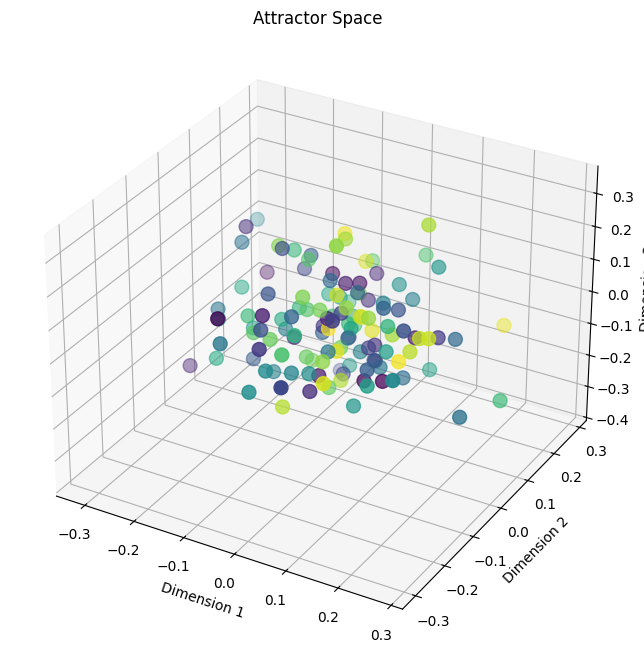

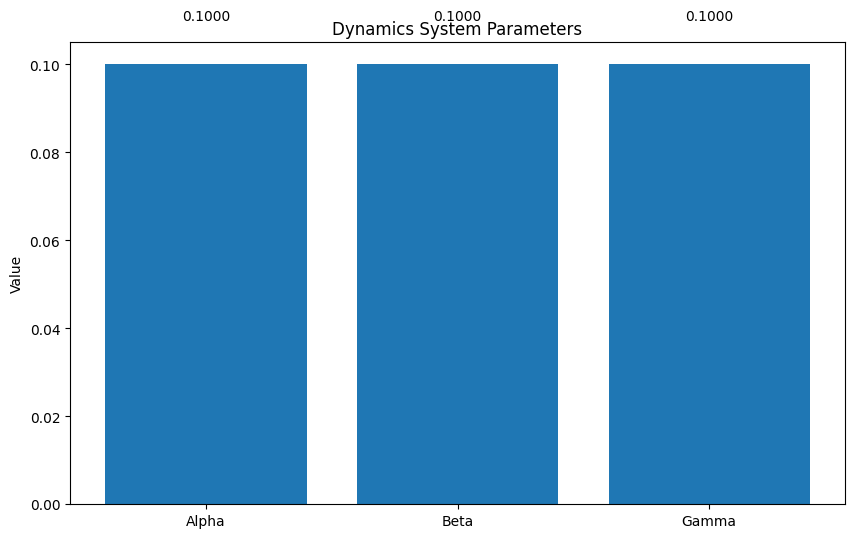

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 简化混沌激励模块
class ChaoticStimulus(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        简化的混沌激励模块
        :param input_dim: 输入维度
        :param output_dim: 输出维度
        """
        super().__init__()
        self.chaos_transform = nn.Sequential(
            nn.Conv1d(input_dim, output_dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(output_dim),
            nn.PReLU(),
            nn.Conv1d(output_dim, output_dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(output_dim),
            nn.PReLU()
        )

        # 混沌扰动参数
        self.chaos_factor = nn.Parameter(torch.tensor(0.1))

    def forward(self, x, multi_scale_features=None):
        """
        前向传播
        :param x: 输入特征 [batch_size, channels, seq_len] 或 [batch_size, seq_len, channels]
        :param multi_scale_features: 来自 DataLoader 的多尺度特征 [batch_size, POOLING_OUTPUT_DIM]
        :return: 嵌入向量和分类结果 
        """
        # 常规特征变换
        transformed = self.chaos_transform(x)

        # 添加混沌扰动
        batch_size, channels, seq_len = transformed.size()
        if self.training:  # 仅在训练时添加混沌扰动
            # 生成与特征相同形状的混沌噪声
            chaos_noise = torch.randn_like(transformed) * self.chaos_factor
            # 应用非线性激活增强混沌特性
            chaos_noise = torch.tanh(chaos_noise)
            transformed = transformed + chaos_noise

        return transformed


# 简化注意力机制
class SimpleAttention(nn.Module):
    def __init__(self, input_dim):
        """
        简化的注意力机制
        :param input_dim: 输入维度
        """
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv1d(input_dim, 1, kernel_size=1),
            nn.Softmax(dim=2)
        )

    def forward(self, x, multi_scale_features=None):
        """
        前向传播
        :param x: 输入特征 [batch_size, channels, seq_len] 或 [batch_size, seq_len, channels]
        :param multi_scale_features: 来自 DataLoader 的多尺度特征 [batch_size, POOLING_OUTPUT_DIM]
        :return: 嵌入向量和分类结果
        """
        # 计算注意力权重 [batch_size, 1, seq_len]
        attn_weights = self.attention(x)

        # 应用注意力权重
        return x * attn_weights


# 复杂奇异吸引子池化层
class StrangeAttractorPooling(nn.Module):
    def __init__(self, input_dim, output_dim, attractor_dim=Config.POOLING_ATTRACTOR_DIM):
        """
        奇异吸引子池化层 - 将时序特征映射到吸引子空间
        :param input_dim: 输入维度
        :param output_dim: 输出维度
        :param attractor_dim: 吸引子空间维度
        """
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.attractor_dim = attractor_dim

        # 投影层
        self.projection = nn.Linear(input_dim, output_dim)

        # 吸引子参数
        self.attractor_weights = nn.Parameter(torch.randn(output_dim, attractor_dim) * 0.1)

        # 动态系统参数
        self.dynamics_alpha = nn.Parameter(torch.tensor(0.1))
        self.dynamics_beta = nn.Parameter(torch.tensor(0.1))
        self.dynamics_gamma = nn.Parameter(torch.tensor(0.1))

    def dynamic_system_step(self, positions, attractors):
        """
        动态系统演化步骤
        :param positions: 当前位置 [batch_size, seq_len, attractor_dim]
        :param attractors: 吸引子位置 [batch_size, output_dim, attractor_dim]
        :return: 更新后的位置
        """
        batch_size, seq_len, _ = positions.size()
        _, num_attractors, _ = attractors.size()

        # 扩展维度以计算所有位置和吸引子之间的距离
        positions_expanded = positions.unsqueeze(2)  # [batch_size, seq_len, 1, attractor_dim]
        attractors_expanded = attractors.unsqueeze(1)  # [batch_size, 1, num_attractors, attractor_dim]

        # 计算距离
        distances = torch.norm(positions_expanded - attractors_expanded, dim=-1)  # [batch_size, seq_len, num_attractors]

        # 计算吸引力（距离越近，吸引力越大）
        attractions = torch.exp(-self.dynamics_alpha * distances)

        # 计算合力方向
        direction_vectors = attractors_expanded - positions_expanded  # [batch_size, seq_len, num_attractors, attractor_dim]
        direction_vectors = F.normalize(direction_vectors, p=2, dim=-1)

        # 计算合力
        forces = torch.sum(attractions.unsqueeze(-1) * direction_vectors, dim=2)  # [batch_size, seq_len, attractor_dim]

        # 添加混沌扰动
        if self.training:
            chaos = torch.randn_like(forces) * self.dynamics_beta
            forces = forces + chaos

        # 更新位置
        new_positions = positions + self.dynamics_gamma * forces

        return new_positions

    def forward(self, x, multi_scale_features):
        """
        前向传播
        :param x: 输入特征 [batch_size, seq_len, input_dim]
        :return: 池化后的特征 [batch_size, output_dim]
        """
        print(f"Input x shape: {x.shape}")  # 调试信息
        print(f"Multi-scale features shape: {multi_scale_features.shape if multi_scale_features is not None else 'None'}")  # 调试信息
        
        batch_size, seq_len, _ = x.size()

        # 确保序列长度足够
        if seq_len < Config.POOLING_MIN_SEQ_LEN:
            # 如果序列太短，使用简单池化
            return torch.mean(x, dim=1)

        # 投影到吸引子空间
        projected = self.projection(x)  # [batch_size, seq_len, output_dim]

        if multi_scale_features is not None:
            # 投影到与 projected 相同维度
            cond_proj = nn.Linear(multi_scale_features.size(1), self.output_dim).to(x.device)
            cond = cond_proj(multi_scale_features).unsqueeze(1).expand(-1, projected.size(1), -1)
            projected = projected + cond  # 使用加法而不是拼接

        # 扩展吸引子参数以匹配批次大小
        attractors = self.attractor_weights.unsqueeze(0).expand(batch_size, -1, -1)  # [batch_size, output_dim, attractor_dim]

        # 初始化位置为投影特征的均值
        initial_positions = torch.mean(projected, dim=1, keepdim=True)  # [batch_size, 1, output_dim]
        
        # 扩展初始位置到吸引子维度
        if self.output_dim != self.attractor_dim:
            # 使用线性变换将output_dim映射到attractor_dim
            position_mapping = nn.Linear(self.output_dim, self.attractor_dim).to(x.device)
            initial_positions = position_mapping(initial_positions)
        else:
            initial_positions = initial_positions.expand(-1, seq_len, -1)  # [batch_size, seq_len, attractor_dim]

        # 动态系统演化
        positions = initial_positions
        for _ in range(5):  # 演化5步
            positions = self.dynamic_system_step(positions, attractors)

        # 计算每个维度与吸引子的最终距离
        positions_expanded = positions.unsqueeze(2)  # [batch_size, seq_len, 1, attractor_dim]
        attractors_expanded = attractors.unsqueeze(1)  # [batch_size, 1, output_dim, attractor_dim]
        
        final_distances = torch.norm(positions_expanded - attractors_expanded, dim=-1)  # [batch_size, seq_len, output_dim]

        # 使用距离作为权重进行加权池化
        weights = F.softmax(-final_distances, dim=1)  # [batch_size, seq_len, output_dim]
        pooled = torch.sum(projected.unsqueeze(2) * weights.unsqueeze(-1), dim=1)  # [batch_size, output_dim, output_dim]

        # 取对角线元素作为最终输出
        pooled = torch.diagonal(pooled, dim1=1, dim2=2)  # [batch_size, output_dim]

        return pooled


# 完整的C-HiLAP模型（简化版+复杂池化）
class CHiLAPModel(nn.Module):
    def __init__(self, input_dim=Config.INPUT_DIM, hidden_dim=Config.HIDDEN_DIM,
                 embedding_dim=Config.EMBEDDING_DIM, num_classes=None):
        """
        混沌层次吸引子传播(C-HiLAP)模型 - 简化版+复杂池化
        """
        super().__init__()

        # 若未传入num_classes，可设置一个默认值（但实际使用时必须从数据集获取后传入）
        if num_classes is None:
            raise ValueError("必须指定num_classes（说话人数量），请从数据集获取后传入")

        # 特征提取层
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(hidden_dim),
            nn.PReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(hidden_dim),
            nn.PReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(hidden_dim),
            nn.PReLU()
        )

        # 混沌激励模块
        self.chaos_layer = ChaoticStimulus(hidden_dim, hidden_dim)

        # 注意力层
        self.attention = SimpleAttention(hidden_dim)

        # TDNN层
        self.tdnn_block = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, dilation=1, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.PReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, dilation=2, padding=2),
            nn.BatchNorm1d(hidden_dim),
            nn.PReLU()
        )

        # 复杂池化层
        self.pooling = StrangeAttractorPooling(hidden_dim, Config.POOLING_OUTPUT_DIM)

        # 嵌入层
        self.embedding = nn.Sequential(
            nn.Linear(Config.POOLING_OUTPUT_DIM, embedding_dim),  # 使用池化输出维度
            nn.BatchNorm1d(embedding_dim),
            nn.PReLU(),
            nn.Dropout(0.2)
        )

        # 分类器
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x, multi_scale_features=None):
        """
        前向传播
        :param x: 输入特征 [batch_size, channels, seq_len] 或 [batch_size, seq_len, channels]
        :return: 嵌入向量和分类结果
        """
        # 检查输入维度并转换为正确的格式 [batch_size, channels, seq_len]
        if x.dim() == 3:
            # 如果是 [batch_size, seq_len, channels] 格式
            if x.size(1) > x.size(2):  # 序列长度应该大于通道数
                x = x.permute(0, 2, 1)  # 转换为 [batch_size, channels, seq_len]

        # 限制序列长度防止内存溢出
        seq_len = x.size(2)
        if seq_len > Config.MAX_SEQ_LEN:
            x = x[:, :, :Config.MAX_SEQ_LEN]

        # 特征提取
        x = self.feature_extractor(x)

        # 混沌处理
        x = self.chaos_layer(x)

        # 注意力机制
        attn_weights = self.attention(x)
        x = x * attn_weights

        # TDNN处理
        x = self.tdnn_block(x)

        # 转换维度: [batch_size, channels, seq_len] -> [batch_size, seq_len, channels]
        x = x.permute(0, 2, 1)

        # 使用多尺度特征的奇怪吸引子池化
        x = self.pooling(x, multi_scale_features)

        # 嵌入向量
        embedding = self.embedding(x)

        # 分类
        logits = self.classifier(embedding)

        return embedding, logits


# 吸引子可视化工具
class AttractorVisualizer:
    def __init__(self):
        pass
    
    @staticmethod
    def plot_attractor_space(attractor_weights, save_path=None):
        """
        绘制吸引子空间
        :param attractor_weights: 吸引子权重 [output_dim, attractor_dim]
        :param save_path: 保存路径
        """
        try:
            attractor_weights = attractor_weights.detach().cpu().numpy()
            
            if attractor_weights.shape[1] == 3:
                # 3D可视化
                fig = plt.figure(figsize=(10, 8))
                ax = fig.add_subplot(111, projection='3d')
                
                ax.scatter(attractor_weights[:, 0], attractor_weights[:, 1], attractor_weights[:, 2], 
                          c=range(attractor_weights.shape[0]), cmap='viridis', s=100)
                
                ax.set_title("Attractor Space")
                ax.set_xlabel("Dimension 1")
                ax.set_ylabel("Dimension 2")
                ax.set_zlabel("Dimension 3")
                
            elif attractor_weights.shape[1] == 2:
                # 2D可视化
                plt.figure(figsize=(10, 8))
                plt.scatter(attractor_weights[:, 0], attractor_weights[:, 1], 
                           c=range(attractor_weights.shape[0]), cmap='viridis', s=100)
                
                plt.title("Attractor Space")
                plt.xlabel("Dimension 1")
                plt.ylabel("Dimension 2")
                plt.colorbar(label='Attractor Index')
                
            else:
                print(f"无法可视化 {attractor_weights.shape[1]} 维吸引子空间")
                return
                
            if save_path:
                plt.savefig(save_path)
                print(f"吸引子空间可视化已保存到: {save_path}")
            else:
                plt.show()
                
        except Exception as e:
            print(f"吸引子空间可视化失败: {e}")
    
    @staticmethod
    def plot_dynamics_parameters(model, save_path=None):
        """
        绘制动态系统参数
        :param model: 模型实例
        :param save_path: 保存路径
        """
        try:
            alpha = model.pooling.dynamics_alpha.detach().cpu().item()
            beta = model.pooling.dynamics_beta.detach().cpu().item()
            gamma = model.pooling.dynamics_gamma.detach().cpu().item()
            
            parameters = [alpha, beta, gamma]
            param_names = ['Alpha', 'Beta', 'Gamma']
            
            plt.figure(figsize=(10, 6))
            plt.bar(param_names, parameters)
            plt.title("Dynamics System Parameters")
            plt.ylabel("Value")
            
            for i, v in enumerate(parameters):
                plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
                
            if save_path:
                plt.savefig(save_path)
                print(f"动态系统参数可视化已保存到: {save_path}")
            else:
                plt.show()
                
        except Exception as e:
            print(f"动态系统参数可视化失败: {e}")


# 测试代码
if __name__ == "__main__":
    # 创建模型实例（示例 num_classes）
    model = CHiLAPModel(num_classes=10)  # 保持不变

    print("模型结构:")
    print(model)

    # 从 dataloader 获取一个 batch 来测试前向传播（使用你之前实现的 get_dataloaders）
    try:
        dataloaders = get_dataloaders(batch_size=2)
        signals, labels, multi_scale_features = next(iter(dataloaders["train"]))
        print(f"从 dataloader 获取到: signals {signals.shape}, labels {labels.shape}, multi_scale_features {multi_scale_features.shape}")

        # signals: [B, MAX_SAMPLES] -> 转为 [B, 1, MAX_SAMPLES] 符合模型输入
        signals = signals.unsqueeze(1)

        # 将 multi_scale_features 转为 float tensor（通常已是 float）
        multi_scale_features = multi_scale_features.float()

        # 前向传播（将 multi_scale_features 传入）
        embedding, logits = model(signals, multi_scale_features)

        print(f"嵌入向量形状: {embedding.shape}")
        print(f"分类输出形状: {logits.shape}")
        print("前向传播成功!")

        # 测试吸引子可视化（可选）
        visualizer = AttractorVisualizer()
        visualizer.plot_attractor_space(model.pooling.attractor_weights, "attractor_space.png")
        visualizer.plot_dynamics_parameters(model, "dynamics_parameters.png")

    except Exception as e:
        print(f"前向传播/测试 出错: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import os
import gc  # 垃圾回收
import math

# 训练器类
class Trainer:
    def __init__(self, config=Config, model=None):
        """初始化训练器"""
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"使用设备: {self.device}")

        # 创建模型
        if model is None:
            raise ValueError("初始化Trainer时必须传入model参数")
        self.model = model.to(self.device)  # 使用传入的模型

        # 定义损失函数
        self.ce_loss = nn.CrossEntropyLoss()

        # 定义优化器
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=config.LR,
            weight_decay=config.WEIGHT_DECAY
        )

        # 学习率调度器
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=3,
        )

        # 学习率预热调度器
        self.warmup_scheduler = optim.lr_scheduler.LambdaLR(
            self.optimizer,
            lr_lambda=lambda epoch: min(1.0, epoch / config.WARMUP_EPOCHS)
        )

        # 混合精度训练
        if config.ENABLE_MIXED_PRECISION and torch.cuda.is_available():
            self.scaler = torch.cuda.amp.GradScaler()
            print("启用混合精度训练")
        else:
            self.scaler = None

        # 创建检查点目录
        os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)

        # 早停计数器
        self.early_stop_counter = 0
        self.best_val_accuracy = 0.0  # 改为基于准确率早停
        print(f"模型预期输入长度: {config.MAX_SEQ_LEN}")

    def train_one_epoch(self, dataloader, epoch):
        """
        训练一个epoch
        :param dataloader: 训练数据加载器
        :param epoch: 当前epoch
        :return: 平均训练损失和准确率
        """
        self.model.train()
        total_loss = 0.0
        total_ce_loss = 0.0
        correct = 0
        total = 0

        # 梯度累积
        accumulation_steps = self.config.GRADIENT_ACCUMULATION_STEPS
        self.optimizer.zero_grad()

        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
        for i, batch in progress_bar:
            try:
                # 解包批次数据 - 现在接收三个值
                inputs, labels, multi_scale_features = batch
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                multi_scale_features = multi_scale_features.to(self.device)

                # 确保输入维度正确 [batch, 1, seq_len]
                if inputs.dim() == 2:  # [batch, seq_len]
                    inputs = inputs.unsqueeze(1)  # 添加通道维度 -> [batch, 1, seq_len]

                # 确保音频长度正确
                if inputs.size(2) > self.config.MAX_SEQ_LEN:
                    inputs = inputs[:, :, :self.config.MAX_SEQ_LEN]
                elif inputs.size(2) < self.config.MAX_SEQ_LEN:
                    pad_len = self.config.MAX_SEQ_LEN - inputs.size(2)
                    inputs = torch.nn.functional.pad(inputs, (0, pad_len), value=0.0)

                # 使用混合精度训练
                if self.scaler is not None:
                    with torch.cuda.amp.autocast():
                        # 前向传播 - 传入多尺度特征
                        embeddings, logits = self.model(inputs, multi_scale_features)

                        # 计算损失
                        ce = self.ce_loss(logits, labels)
                        loss = self.config.CE_WEIGHT * ce

                        # 梯度累积
                        loss = loss / accumulation_steps

                    # 反向传播
                    self.scaler.scale(loss).backward()

                    # 梯度裁剪
                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.GRAD_CLIP)

                    if (i + 1) % accumulation_steps == 0:
                        self.scaler.step(self.optimizer)  # 优化器步骤
                        self.scaler.update()
                        # 2. 再调用预热调度器
                        if epoch <= self.config.WARMUP_EPOCHS:
                            self.warmup_scheduler.step()
                        self.optimizer.zero_grad()

                else:
                    # 标准训练（不使用混合精度）
                    embeddings, logits = self.model(inputs, multi_scale_features)

                    # 计算损失
                    ce = self.ce_loss(logits, labels)
                    loss = self.config.CE_WEIGHT * ce

                    # 梯度累积
                    loss = loss / accumulation_steps
                    loss.backward()

                    # 梯度裁剪
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.GRAD_CLIP)

                    if (i + 1) % accumulation_steps == 0:
                        # 1. 先更新参数
                        self.optimizer.step()
                        # 2. 再调用学习率预热调度器（仅在预热阶段）
                        if epoch <= self.config.WARMUP_EPOCHS:
                            self.warmup_scheduler.step()  # 移动到optimizer.step()之后
                        self.optimizer.zero_grad()

                # 统计
                total_loss += loss.item() * accumulation_steps
                total_ce_loss += ce.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # 更新进度条
                if i % 10 == 0:  # 减少更新频率
                    accuracy = 100. * correct / total
                    avg_loss = total_loss / (i + 1)
                    progress_bar.set_description(
                        f"Epoch {epoch}, Loss: {avg_loss:.4f}, Acc: {accuracy:.2f}%"
                    )

                # 手动垃圾回收
                if i % 50 == 0:
                    torch.cuda.empty_cache()
                    gc.collect()

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"内存不足错误在批次 {i}: {e}")
                    torch.cuda.empty_cache()
                    gc.collect()
                    continue
                else:
                    raise e

        avg_loss = total_loss / len(dataloader)
        accuracy = 100. * correct / total
        return avg_loss, accuracy

    def validate(self, dataloader):
        """
        验证模型性能
        :param dataloader: 验证数据加载器
        :return: 验证损失和准确率
        """
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for i, batch in enumerate(dataloader):
                try:
                    # 解包批次数据 - 现在接收三个值
                    inputs, labels, multi_scale_features = batch
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    multi_scale_features = multi_scale_features.to(self.device)

                    # 确保输入维度正确 [batch, 1, seq_len]
                    if inputs.dim() == 2:  # [batch, seq_len]
                        inputs = inputs.unsqueeze(1)  # 添加通道维度 -> [batch, 1, seq_len]

                    # 确保音频长度正确
                    if inputs.size(2) > self.config.MAX_SEQ_LEN:
                        inputs = inputs[:, :, :self.config.MAX_SEQ_LEN]
                    elif inputs.size(2) < self.config.MAX_SEQ_LEN:
                        pad_len = self.config.MAX_SEQ_LEN - inputs.size(2)
                        inputs = torch.nn.functional.pad(inputs, (0, pad_len), value=0.0)

                    # 前向传播 - 传入多尺度特征
                    embeddings, logits = self.model(inputs, multi_scale_features)

                    # 计算损失
                    ce = self.ce_loss(logits, labels)
                    loss = self.config.CE_WEIGHT * ce

                    total_loss += loss.item()

                    # 统计准确率
                    _, predicted = logits.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                    # 内存管理
                    if i % 20 == 0:
                        torch.cuda.empty_cache()
                        gc.collect()

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"验证时内存不足: {e}")
                        torch.cuda.empty_cache()
                        gc.collect()
                        continue
                    else:
                        raise e

        avg_loss = total_loss / len(dataloader)
        accuracy = 100. * correct / total
        return avg_loss, accuracy

    def train(self, train_dataloader, val_dataloader):
        """
        完整训练流程
        :param train_dataloader: 训练数据加载器
        :param val_dataloader: 验证数据加载器
        """
        print("开始训练...")
        print(f"训练集批次: {len(train_dataloader)}, 验证集批次: {len(val_dataloader)}")

        for epoch in range(1, self.config.EPOCHS + 1):
            try:
                # 应用学习率预热
                if epoch <= self.config.WARMUP_EPOCHS:
                    self.warmup_scheduler.step()

                # 训练一个epoch
                train_loss, train_acc = self.train_one_epoch(train_dataloader, epoch)
                print(f"Epoch {epoch}/{self.config.EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

                # 验证
                val_loss, val_acc = self.validate(val_dataloader)
                print(f"Epoch {epoch}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

                # 更新学习率
                self.scheduler.step(val_loss)
                current_lr = self.optimizer.param_groups[0]['lr']
                print(f"当前学习率: {current_lr:.6f}")

                # 早停检查 (基于验证准确率)
                if val_acc > self.best_val_accuracy + self.config.MIN_DELTA:
                    self.best_val_accuracy = val_acc
                    self.early_stop_counter = 0
                    # 保存最佳模型
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_loss': val_loss,
                        'val_accuracy': val_acc
                    }, os.path.join(self.config.CHECKPOINT_DIR, 'best_model.pth'))
                    print(f"保存最佳模型，验证准确率: {val_acc:.2f}%")
                else:
                    self.early_stop_counter += 1
                    if self.early_stop_counter >= self.config.PATIENCE:
                        print(f"早停于第 {epoch} 轮")
                        break

                # 定期保存模型
                if epoch % self.config.SAVE_INTERVAL == 0:
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'train_loss': train_loss,
                        'train_accuracy': train_acc
                    }, os.path.join(self.config.CHECKPOINT_DIR, f'model_epoch_{epoch}.pth'))

                # 清理内存
                torch.cuda.empty_cache()
                gc.collect()

            except KeyboardInterrupt:
                print("训练被用户中断")
                break
            except Exception as e:
                print(f"训练错误: {e}")
                torch.cuda.empty_cache()
                gc.collect()
                continue

    def load_checkpoint(self, checkpoint_path):
        """
        加载检查点
        :param checkpoint_path: 检查点路径
        """
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        if 'optimizer_state_dict' in checkpoint:
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint.get('epoch', 0)
        print(f"从第 {epoch} 轮加载检查点")
        return epoch

# 评估器类
class Evaluator:
    def __init__(self, model, config=Config):
        """初始化评估器"""
        self.model = model
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()

    def evaluate_accuracy(self, dataloader):
        """
        评估模型准确率
        :param dataloader: 数据加载器
        :return: 准确率
        """
        correct = 0
        total = 0

        with torch.no_grad():
            for i, batch in enumerate(dataloader):
                try:
                    # 解包批次数据 - 现在接收三个值
                    inputs, labels, multi_scale_features = batch
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    multi_scale_features = multi_scale_features.to(self.device)

                    # 确保输入维度正确
                    if inputs.dim() == 2:  # [batch, seq_len]
                        inputs = inputs.unsqueeze(1)  # 添加通道维度 -> [batch, 1, seq_len]

                    # 截断过长的序列
                    if inputs.size(2) > self.config.MAX_SEQ_LEN:
                        inputs = inputs[:, :, :self.config.MAX_SEQ_LEN]

                    # 前向传播 - 传入多尺度特征
                    _, logits = self.model(inputs, multi_scale_features)
                    _, predicted = logits.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                    # 内存管理
                    if i % 20 == 0:
                        torch.cuda.empty_cache()
                        gc.collect()

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"评估时内存不足: {e}")
                        torch.cuda.empty_cache()
                        gc.collect()
                        continue
                    else:
                        raise e

        accuracy = 100. * correct / total
        return accuracy

# 测试代码
if __name__ == "__main__":
    # 设置较小的批次大小
    batch_size = Config.BATCH_SIZE

    print("创建数据加载器...")
    try:
        dataloaders = get_dataloaders(batch_size=batch_size)

        if dataloaders is None:
            print("无法创建数据加载器，退出")
            exit(1)

        print(f"训练集批次数: {len(dataloaders['train'])}")
        print(f"验证集批次数: {len(dataloaders['val'])}")
        print(f"测试集批次数: {len(dataloaders['test'])}")

        # 关键修改：从训练集中获取实际说话人数量（类别数）
        num_speakers = len(dataloaders["train"].dataset.speaker_to_idx)
        print(f"数据集中实际说话人数量（类别数）: {num_speakers}")

        # 创建训练器前，先初始化模型并传入正确的num_classes
        print("创建模型和训练器...")
        # 关键修改：确保在创建Trainer时使用正确的num_classes初始化模型
        # 1. 初始化模型（传入正确的num_classes）
        model = CHiLAPModel(num_classes=num_speakers)
        # 2. 将模型传入Trainer，确保优化器初始化时模型已存在
        trainer = Trainer(config=Config, model=model)  # 传入model参数

        # 测试一个批次
        print("测试前向传播...")
        try:
            # 修改：接收三个返回值
            x, y, multi_scale_features = next(iter(dataloaders["train"]))
            print(f"原始输入形状: {x.shape}, 标签形状: {y.shape}, 多尺度特征形状: {multi_scale_features.shape}")

            # 处理输入维度
            if x.dim() == 2:  # [batch, seq_len]
                x = x.unsqueeze(1)  # 添加通道维度 -> [batch, 1, seq_len]

            # 确保音频长度正确
            if x.size(2) > Config.MAX_SEQ_LEN:
                x = x[:, :, :Config.MAX_SEQ_LEN]
            elif x.size(2) < Config.MAX_SEQ_LEN:
                pad_len = Config.MAX_SEQ_LEN - x.size(2)
                x = torch.nn.functional.pad(x, (0, pad_len), value=0.0)

            print(f"处理后输入形状: {x.shape}")

            x = x.to(trainer.device)
            y = y.to(trainer.device)
            multi_scale_features = multi_scale_features.to(trainer.device)

            with torch.no_grad():
                # 修改：传入多尺度特征
                embeddings, logits = trainer.model(x, multi_scale_features)
                print(f"嵌入形状: {embeddings.shape}, 输出形状: {logits.shape}")
                print("前向传播测试成功!")
        except Exception as e:
            print(f"前向传播测试失败: {e}")
            import traceback
            traceback.print_exc()
            exit(1)

        # 开始训练
        print("开始训练...")
        trainer.train(dataloaders["train"], dataloaders["val"])

        # 创建评估器
        print("创建评估器...")
        evaluator = Evaluator(trainer.model)

        # 评估模型
        print("评估模型...")
        test_accuracy = evaluator.evaluate_accuracy(dataloaders["test"])
        print(f"测试集准确率: {test_accuracy:.2f}%")

    except Exception as e:
        print(f"程序执行错误: {e}")
        import traceback
        traceback.print_exc()

创建数据加载器...
加载LibriSpeech数据集: /users/tianyuey/Project/devDataset/LibriSpeech
处理子集: dev-clean
在 dev-clean 中找到 2703 个.flac文件
处理子集: dev-other
在 dev-other 中找到 5567 个.flac文件
找到 73 个不同的说话人
有效文件: 5000/5000
移除 0 个无效文件
找到 73 个不同的说话人
最终 train 数据集大小: 5000 个样本
加载LibriSpeech数据集: /users/tianyuey/Project/devDataset/LibriSpeech
处理子集: dev-clean
在 dev-clean 中找到 2703 个.flac文件
处理子集: dev-other
在 dev-other 中找到 5567 个.flac文件
找到 73 个不同的说话人
有效文件: 557/557
移除 0 个无效文件
找到 73 个不同的说话人
最终 val 数据集大小: 557 个样本
加载LibriSpeech数据集: /users/tianyuey/Project/devDataset/LibriSpeech
处理子集: dev-clean
在 dev-clean 中找到 2703 个.flac文件
处理子集: dev-other
在 dev-other 中找到 5567 个.flac文件
找到 73 个不同的说话人
有效文件: 5567/5567
移除 0 个无效文件
找到 73 个不同的说话人
最终 test 数据集大小: 5567 个样本
加载LibriSpeech数据集: /users/tianyuey/Project/devDataset/LibriSpeech
处理子集: dev-clean
在 dev-clean 中找到 2703 个.flac文件
处理子集: dev-other
在 dev-other 中找到 5567 个.flac文件
找到 73 个不同的说话人
有效文件: 5567/5567
移除 0 个无效文件
找到 73 个不同的说话人
最终 test 数据集大小: 5567 个样本
训练集: 5000 样本
验证集: 557 样本
测试集: 5567 样本
带噪声测试集: 55

/usr/local/lib64/python3.12/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/313 [00:00<?, ?it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 0: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 340.50 MiB is free. Including non-PyTorch memory, this process has 4.41 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1.18 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  0%|          | 1/313 [00:01<09:48,  1.89s/it]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 1: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 576.50 MiB is free. Including non-PyTorch memory, this process has 4.18 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 973.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|          | 2/313 [00:02<05:02,  1.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 2: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 366.50 MiB is free. Including non-PyTorch memory, this process has 4.38 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.15 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|          | 3/313 [00:02<03:30,  1.47it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 3: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|▏         | 4/313 [00:02<02:57,  1.75it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 4: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 5/313 [00:03<02:28,  2.08it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 5: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 6/313 [00:03<02:13,  2.29it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 6: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 7/313 [00:03<01:55,  2.65it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 7: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 8/313 [00:04<01:49,  2.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 8: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 9/313 [00:04<01:38,  3.09it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 9: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 10/313 [00:04<01:31,  3.31it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 10: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▎         | 11/313 [00:04<01:26,  3.50it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 11: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▍         | 12/313 [00:05<01:33,  3.21it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 12: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▍         | 13/313 [00:05<01:43,  2.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 13: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▍         | 14/313 [00:06<01:37,  3.08it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 14: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  5%|▍         | 15/313 [00:06<01:31,  3.25it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 15: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  5%|▌         | 16/313 [00:06<01:27,  3.39it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 16: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  5%|▌         | 17/313 [00:06<01:22,  3.57it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 17: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  6%|▌         | 18/313 [00:07<01:20,  3.67it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 18: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  6%|▌         | 19/313 [00:07<01:24,  3.47it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 19: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  6%|▋         | 20/313 [00:07<01:21,  3.59it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 20: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  7%|▋         | 21/313 [00:07<01:18,  3.70it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 21: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  7%|▋         | 22/313 [00:08<01:17,  3.76it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 22: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  7%|▋         | 23/313 [00:08<01:15,  3.82it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 23: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  8%|▊         | 24/313 [00:08<01:15,  3.85it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 24: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  8%|▊         | 25/313 [00:08<01:13,  3.90it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 25: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  8%|▊         | 26/313 [00:09<01:13,  3.91it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 26: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  9%|▊         | 27/313 [00:09<01:12,  3.93it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 27: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  9%|▉         | 28/313 [00:09<01:12,  3.93it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 28: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  9%|▉         | 29/313 [00:09<01:11,  3.95it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 29: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|▉         | 30/313 [00:10<01:11,  3.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 30: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|▉         | 31/313 [00:10<01:11,  3.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 31: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|█         | 32/313 [00:10<01:13,  3.83it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 32: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 11%|█         | 33/313 [00:11<01:19,  3.53it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 33: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 11%|█         | 34/313 [00:11<01:16,  3.65it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 34: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 11%|█         | 35/313 [00:11<01:13,  3.76it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 35: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 36/313 [00:12<01:35,  2.90it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 36: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 37/313 [00:12<01:32,  2.99it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 37: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 38/313 [00:12<01:38,  2.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 38: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 39/313 [00:13<01:32,  2.97it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 39: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 13%|█▎        | 40/313 [00:13<01:33,  2.93it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 40: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 13%|█▎        | 41/313 [00:13<01:38,  2.77it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 41: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 14%|█▎        | 43/313 [00:14<01:30,  2.97it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 42: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 43: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, 

 14%|█▍        | 44/313 [00:14<01:27,  3.07it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 44: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 14%|█▍        | 45/313 [00:15<01:24,  3.16it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 45: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 15%|█▍        | 46/313 [00:15<01:24,  3.15it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 46: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 15%|█▌        | 47/313 [00:15<01:32,  2.87it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 47: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 15%|█▌        | 48/313 [00:16<01:25,  3.09it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 48: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 16%|█▌        | 49/313 [00:16<01:24,  3.12it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 49: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 16%|█▌        | 50/313 [00:16<01:29,  2.95it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 50: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 16%|█▋        | 51/313 [00:17<01:26,  3.04it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 51: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 17%|█▋        | 52/313 [00:17<01:28,  2.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 52: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 17%|█▋        | 53/313 [00:17<01:25,  3.04it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 53: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 17%|█▋        | 54/313 [00:17<01:20,  3.21it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 54: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 18%|█▊        | 55/313 [00:18<01:22,  3.13it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 55: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 18%|█▊        | 56/313 [00:18<01:37,  2.64it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 56: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 18%|█▊        | 57/313 [00:19<01:25,  2.99it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 57: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▊        | 58/313 [00:19<01:43,  2.47it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 58: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▉        | 59/313 [00:20<01:43,  2.46it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 59: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▉        | 60/313 [00:20<01:40,  2.52it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 60: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▉        | 61/313 [00:20<01:29,  2.82it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 61: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 20%|█▉        | 62/313 [00:20<01:21,  3.06it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 62: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 20%|██        | 63/313 [00:21<01:16,  3.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 63: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 20%|██        | 64/313 [00:21<01:10,  3.55it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 64: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██        | 65/313 [00:21<01:16,  3.24it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 65: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██        | 66/313 [00:22<01:13,  3.34it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 66: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██▏       | 67/313 [00:22<01:09,  3.52it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 67: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 22%|██▏       | 68/313 [00:22<01:07,  3.61it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 68: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 22%|██▏       | 69/313 [00:22<01:05,  3.71it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 69: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 22%|██▏       | 70/313 [00:23<01:05,  3.71it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 70: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 23%|██▎       | 71/313 [00:23<01:12,  3.35it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 71: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 23%|██▎       | 72/313 [00:23<01:19,  3.05it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 72: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 23%|██▎       | 73/313 [00:24<01:14,  3.23it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 73: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 24%|██▎       | 74/313 [00:24<01:11,  3.34it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 74: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 24%|██▍       | 75/313 [00:24<01:07,  3.52it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 75: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 24%|██▍       | 76/313 [00:24<01:05,  3.62it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 76: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 25%|██▍       | 77/313 [00:25<01:03,  3.72it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 77: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 25%|██▍       | 78/313 [00:25<01:03,  3.73it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 78: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 25%|██▌       | 79/313 [00:25<01:01,  3.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 79: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 26%|██▌       | 80/313 [00:25<01:00,  3.84it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 80: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 26%|██▌       | 81/313 [00:26<00:59,  3.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 81: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 26%|██▌       | 82/313 [00:26<00:59,  3.90it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 82: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 27%|██▋       | 83/313 [00:26<00:58,  3.93it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 83: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 27%|██▋       | 84/313 [00:26<00:58,  3.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 84: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 27%|██▋       | 85/313 [00:27<01:02,  3.64it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 85: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 27%|██▋       | 86/313 [00:27<01:03,  3.59it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 86: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 28%|██▊       | 87/313 [00:27<01:04,  3.49it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 87: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 28%|██▊       | 88/313 [00:28<01:06,  3.39it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 88: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 28%|██▊       | 89/313 [00:28<01:05,  3.41it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 89: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 29%|██▉       | 90/313 [00:28<01:03,  3.53it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 90: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 29%|██▉       | 91/313 [00:28<01:00,  3.65it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 91: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 29%|██▉       | 92/313 [00:29<00:58,  3.75it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 92: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 30%|██▉       | 93/313 [00:29<00:57,  3.80it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 93: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 30%|███       | 94/313 [00:29<01:07,  3.25it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 94: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 30%|███       | 95/313 [00:30<01:08,  3.20it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 95: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 31%|███       | 96/313 [00:30<01:06,  3.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 96: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 31%|███       | 97/313 [00:30<01:05,  3.32it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 97: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 31%|███▏      | 98/313 [00:31<01:02,  3.45it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 98: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 32%|███▏      | 99/313 [00:31<01:00,  3.56it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 99: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 32%|███▏      | 100/313 [00:31<01:00,  3.50it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 100: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 32%|███▏      | 101/313 [00:31<01:01,  3.46it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 101: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 33%|███▎      | 102/313 [00:32<00:59,  3.54it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 102: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 33%|███▎      | 103/313 [00:32<00:57,  3.66it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 103: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 33%|███▎      | 104/313 [00:32<00:56,  3.71it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 104: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 34%|███▎      | 105/313 [00:32<00:55,  3.77it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 105: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 34%|███▍      | 106/313 [00:33<00:56,  3.64it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 106: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 34%|███▍      | 107/313 [00:33<01:08,  3.02it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 107: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▍      | 108/313 [00:34<01:07,  3.06it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 108: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▍      | 109/313 [00:34<01:03,  3.24it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 109: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▌      | 110/313 [00:34<01:03,  3.22it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 110: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▌      | 111/313 [00:34<01:05,  3.07it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 111: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 36%|███▌      | 112/313 [00:35<01:08,  2.95it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 112: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 36%|███▌      | 113/313 [00:35<01:04,  3.09it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 113: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 36%|███▋      | 114/313 [00:35<01:01,  3.25it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 114: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 37%|███▋      | 115/313 [00:36<01:00,  3.27it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 115: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 37%|███▋      | 116/313 [00:36<01:09,  2.84it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 116: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 37%|███▋      | 117/313 [00:37<01:08,  2.84it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 117: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 38%|███▊      | 118/313 [00:37<01:03,  3.09it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 118: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 38%|███▊      | 119/313 [00:37<01:04,  2.99it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 119: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 38%|███▊      | 120/313 [00:37<01:03,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 120: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 39%|███▊      | 121/313 [00:38<01:00,  3.17it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 121: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 39%|███▉      | 122/313 [00:38<01:07,  2.84it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 122: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 39%|███▉      | 123/313 [00:38<01:01,  3.08it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 123: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|███▉      | 124/313 [00:39<01:07,  2.82it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 124: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|███▉      | 125/313 [00:39<01:02,  3.01it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 125: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|████      | 126/313 [00:40<01:06,  2.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 126: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 41%|████      | 127/313 [00:40<01:01,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 127: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 41%|████      | 128/313 [00:40<01:00,  3.04it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 128: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 41%|████      | 129/313 [00:40<00:56,  3.27it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 129: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 130/313 [00:41<00:53,  3.44it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 130: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 131/313 [00:41<00:50,  3.59it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 131: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 132/313 [00:41<00:49,  3.67it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 132: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 133/313 [00:42<00:52,  3.40it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 133: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 43%|████▎     | 134/313 [00:42<00:51,  3.49it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 134: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 43%|████▎     | 135/313 [00:42<00:59,  3.00it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 135: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 43%|████▎     | 136/313 [00:43<00:57,  3.06it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 136: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 44%|████▍     | 137/313 [00:43<01:00,  2.92it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 137: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 44%|████▍     | 138/313 [00:43<00:58,  3.00it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 138: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 44%|████▍     | 139/313 [00:43<00:54,  3.20it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 139: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 45%|████▍     | 140/313 [00:44<00:51,  3.35it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 140: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 45%|████▌     | 141/313 [00:44<00:52,  3.28it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 141: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 45%|████▌     | 142/313 [00:45<01:12,  2.35it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 142: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 46%|████▌     | 143/313 [00:45<01:06,  2.55it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 143: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 46%|████▌     | 144/313 [00:45<00:59,  2.82it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 144: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 46%|████▋     | 145/313 [00:46<00:54,  3.09it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 145: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 47%|████▋     | 146/313 [00:46<00:50,  3.30it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 146: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 47%|████▋     | 147/313 [00:46<00:47,  3.48it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 147: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 47%|████▋     | 148/313 [00:47<00:59,  2.77it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 148: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 149/313 [00:47<01:11,  2.31it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 149: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 150/313 [00:48<01:05,  2.50it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 150: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 151/313 [00:48<00:56,  2.86it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 151: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 49%|████▊     | 152/313 [00:48<00:56,  2.87it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 152: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 49%|████▉     | 153/313 [00:49<00:56,  2.85it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 153: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 49%|████▉     | 154/313 [00:49<00:51,  3.10it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 154: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|████▉     | 155/313 [00:49<00:49,  3.20it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 155: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|████▉     | 156/313 [00:49<00:46,  3.36it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 156: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|█████     | 157/313 [00:50<00:44,  3.49it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 157: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|█████     | 158/313 [00:50<00:43,  3.59it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 158: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 51%|█████     | 159/313 [00:50<00:42,  3.61it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 159: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 51%|█████     | 160/313 [00:50<00:42,  3.60it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 160: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 51%|█████▏    | 161/313 [00:51<00:43,  3.52it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 161: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 52%|█████▏    | 162/313 [00:51<00:47,  3.20it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 162: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 52%|█████▏    | 163/313 [00:52<00:53,  2.82it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 163: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 52%|█████▏    | 164/313 [00:52<00:56,  2.64it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 164: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 53%|█████▎    | 165/313 [00:52<00:56,  2.62it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 165: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 53%|█████▎    | 166/313 [00:53<00:51,  2.83it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 166: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 53%|█████▎    | 167/313 [00:53<00:50,  2.90it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 167: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 54%|█████▎    | 168/313 [00:53<00:47,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 168: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 54%|█████▍    | 169/313 [00:54<00:44,  3.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 169: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 54%|█████▍    | 170/313 [00:54<00:46,  3.10it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 170: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 55%|█████▍    | 171/313 [00:54<00:43,  3.29it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 171: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 55%|█████▍    | 172/313 [00:54<00:40,  3.45it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 172: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 55%|█████▌    | 173/313 [00:55<00:42,  3.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 173: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 56%|█████▌    | 174/313 [00:55<00:44,  3.12it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 174: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 56%|█████▌    | 175/313 [00:55<00:42,  3.22it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 175: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 56%|█████▌    | 176/313 [00:56<00:42,  3.24it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 176: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 57%|█████▋    | 178/313 [00:57<00:51,  2.60it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 177: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 178: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTo

 57%|█████▋    | 179/313 [00:57<00:46,  2.88it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 179: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 180/313 [00:57<00:44,  2.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 180: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 181/313 [00:57<00:42,  3.12it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 181: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 182/313 [00:58<00:39,  3.29it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 182: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 59%|█████▉    | 184/313 [00:58<00:41,  3.12it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 183: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 184: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTo

 59%|█████▉    | 185/313 [00:59<00:41,  3.05it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 185: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 59%|█████▉    | 186/313 [00:59<00:40,  3.15it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 186: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 60%|█████▉    | 187/313 [00:59<00:37,  3.37it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 187: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 60%|██████    | 188/313 [00:59<00:35,  3.49it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 188: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 60%|██████    | 189/313 [01:00<00:38,  3.22it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 189: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 61%|██████    | 190/313 [01:00<00:36,  3.36it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 190: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 61%|██████    | 191/313 [01:00<00:35,  3.40it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 191: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 61%|██████▏   | 192/313 [01:01<00:34,  3.49it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 192: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 62%|██████▏   | 193/313 [01:01<00:35,  3.34it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 193: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 62%|██████▏   | 194/313 [01:01<00:39,  3.05it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 194: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 62%|██████▏   | 195/313 [01:02<00:42,  2.77it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 195: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 63%|██████▎   | 196/313 [01:02<00:43,  2.67it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 196: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 63%|██████▎   | 197/313 [01:02<00:39,  2.92it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 197: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 63%|██████▎   | 198/313 [01:03<00:37,  3.09it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 198: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 64%|██████▎   | 199/313 [01:03<00:34,  3.31it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 199: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 64%|██████▍   | 200/313 [01:03<00:33,  3.40it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 200: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 64%|██████▍   | 201/313 [01:04<00:31,  3.55it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 201: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 65%|██████▍   | 202/313 [01:04<00:30,  3.60it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 202: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 65%|██████▍   | 203/313 [01:04<00:30,  3.57it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 203: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 65%|██████▌   | 204/313 [01:04<00:31,  3.51it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 204: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 65%|██████▌   | 205/313 [01:05<00:31,  3.45it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 205: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 66%|██████▌   | 206/313 [01:05<00:33,  3.15it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 206: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 66%|██████▌   | 207/313 [01:05<00:34,  3.06it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 207: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 66%|██████▋   | 208/313 [01:06<00:33,  3.13it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 208: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 67%|██████▋   | 209/313 [01:06<00:37,  2.80it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 209: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 67%|██████▋   | 210/313 [01:07<00:42,  2.42it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 210: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 396.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 67%|██████▋   | 211/313 [01:07<00:39,  2.57it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 211: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 68%|██████▊   | 212/313 [01:07<00:38,  2.59it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 212: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 68%|██████▊   | 213/313 [01:08<00:34,  2.86it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 213: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 68%|██████▊   | 214/313 [01:08<00:40,  2.44it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 214: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 69%|██████▊   | 215/313 [01:09<00:36,  2.67it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 215: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 69%|██████▉   | 216/313 [01:09<00:36,  2.65it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 216: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 69%|██████▉   | 217/313 [01:09<00:32,  2.92it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 217: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 70%|██████▉   | 218/313 [01:10<00:34,  2.73it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 218: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 70%|██████▉   | 219/313 [01:10<00:32,  2.88it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 219: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 70%|███████   | 220/313 [01:10<00:33,  2.78it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 220: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 71%|███████   | 221/313 [01:11<00:31,  2.91it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 221: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 71%|███████   | 222/313 [01:11<00:29,  3.08it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 222: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 71%|███████   | 223/313 [01:11<00:29,  3.09it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 223: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 72%|███████▏  | 224/313 [01:11<00:27,  3.29it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 224: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 72%|███████▏  | 225/313 [01:12<00:25,  3.44it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 225: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 72%|███████▏  | 226/313 [01:12<00:26,  3.33it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 226: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 227/313 [01:12<00:24,  3.50it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 227: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 228/313 [01:13<00:23,  3.62it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 228: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 229/313 [01:13<00:22,  3.73it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 229: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 230/313 [01:13<00:21,  3.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 230: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 74%|███████▍  | 231/313 [01:13<00:21,  3.78it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 231: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 74%|███████▍  | 232/313 [01:14<00:22,  3.63it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 232: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 74%|███████▍  | 233/313 [01:14<00:26,  3.01it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 233: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▍  | 234/313 [01:14<00:24,  3.24it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 234: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▌  | 235/313 [01:15<00:29,  2.66it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 235: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▌  | 236/313 [01:15<00:26,  2.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 236: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 76%|███████▌  | 237/313 [01:16<00:27,  2.76it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 237: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 76%|███████▌  | 238/313 [01:16<00:25,  2.98it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 238: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 76%|███████▋  | 239/313 [01:16<00:23,  3.16it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 239: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 77%|███████▋  | 240/313 [01:16<00:21,  3.35it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 240: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 77%|███████▋  | 241/313 [01:17<00:20,  3.51it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 241: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 77%|███████▋  | 242/313 [01:17<00:19,  3.61it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 242: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 243/313 [01:17<00:18,  3.71it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 243: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 244/313 [01:17<00:18,  3.77it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 244: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 245/313 [01:18<00:18,  3.67it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 245: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 79%|███████▊  | 246/313 [01:18<00:17,  3.73it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 246: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 79%|███████▉  | 247/313 [01:18<00:17,  3.80it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 247: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 79%|███████▉  | 248/313 [01:18<00:16,  3.84it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 248: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 80%|███████▉  | 249/313 [01:19<00:16,  3.88it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 249: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 80%|███████▉  | 250/313 [01:19<00:17,  3.51it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 250: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 80%|████████  | 251/313 [01:19<00:18,  3.38it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 251: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 81%|████████  | 252/313 [01:20<00:22,  2.72it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 252: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 81%|████████  | 253/313 [01:20<00:20,  2.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 253: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 81%|████████  | 254/313 [01:20<00:18,  3.14it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 254: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 81%|████████▏ | 255/313 [01:21<00:18,  3.21it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 255: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 82%|████████▏ | 256/313 [01:21<00:16,  3.39it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 256: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 82%|████████▏ | 257/313 [01:21<00:15,  3.55it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 257: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 82%|████████▏ | 258/313 [01:22<00:16,  3.31it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 258: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 83%|████████▎ | 259/313 [01:22<00:15,  3.38it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 259: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 83%|████████▎ | 260/313 [01:22<00:15,  3.33it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 260: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 83%|████████▎ | 261/313 [01:22<00:15,  3.31it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 261: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 84%|████████▎ | 262/313 [01:23<00:14,  3.46it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 262: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 84%|████████▍ | 263/313 [01:23<00:14,  3.53it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 263: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 84%|████████▍ | 264/313 [01:23<00:14,  3.49it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 264: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 85%|████████▍ | 265/313 [01:24<00:13,  3.50it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 265: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 85%|████████▍ | 266/313 [01:24<00:13,  3.60it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 266: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 85%|████████▌ | 267/313 [01:24<00:14,  3.17it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 267: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 86%|████████▌ | 268/313 [01:25<00:13,  3.34it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 268: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 86%|████████▌ | 269/313 [01:25<00:17,  2.45it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 269: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 86%|████████▋ | 270/313 [01:25<00:15,  2.75it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 270: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 87%|████████▋ | 271/313 [01:26<00:15,  2.77it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 271: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 87%|████████▋ | 272/313 [01:26<00:13,  3.02it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 272: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 87%|████████▋ | 273/313 [01:26<00:12,  3.17it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 273: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 88%|████████▊ | 274/313 [01:27<00:12,  3.21it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 274: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 88%|████████▊ | 275/313 [01:27<00:12,  2.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 275: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 88%|████████▊ | 276/313 [01:27<00:12,  2.97it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 276: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 89%|████████▉ | 278/313 [01:28<00:12,  2.91it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 277: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 278: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTo

 89%|████████▉ | 279/313 [01:28<00:10,  3.17it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 279: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 89%|████████▉ | 280/313 [01:29<00:13,  2.45it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 280: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 90%|████████▉ | 281/313 [01:29<00:11,  2.76it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 281: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 90%|█████████ | 282/313 [01:29<00:10,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 282: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 90%|█████████ | 283/313 [01:30<00:09,  3.28it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 283: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 91%|█████████ | 284/313 [01:30<00:10,  2.82it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 284: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 91%|█████████ | 285/313 [01:30<00:09,  2.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 285: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 91%|█████████▏| 286/313 [01:31<00:08,  3.07it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 286: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 92%|█████████▏| 287/313 [01:31<00:08,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 287: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 92%|█████████▏| 288/313 [01:31<00:08,  3.11it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 288: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 92%|█████████▏| 289/313 [01:32<00:07,  3.29it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 289: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 93%|█████████▎| 290/313 [01:32<00:06,  3.47it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 290: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 93%|█████████▎| 291/313 [01:32<00:06,  3.61it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 291: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 93%|█████████▎| 292/313 [01:33<00:06,  3.15it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 292: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 94%|█████████▎| 293/313 [01:33<00:06,  3.15it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 293: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 94%|█████████▍| 294/313 [01:33<00:05,  3.36it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 294: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 94%|█████████▍| 295/313 [01:33<00:05,  3.53it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 295: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 95%|█████████▍| 296/313 [01:34<00:04,  3.64it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 296: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 95%|█████████▍| 297/313 [01:34<00:04,  3.51it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 297: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 95%|█████████▌| 298/313 [01:34<00:04,  3.51it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 298: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 96%|█████████▌| 299/313 [01:35<00:03,  3.59it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 299: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 96%|█████████▌| 300/313 [01:35<00:03,  3.68it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 300: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 96%|█████████▌| 301/313 [01:35<00:03,  3.67it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 301: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 96%|█████████▋| 302/313 [01:35<00:03,  3.58it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 302: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 97%|█████████▋| 303/313 [01:36<00:02,  3.59it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 303: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 97%|█████████▋| 304/313 [01:36<00:02,  3.50it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 304: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 97%|█████████▋| 305/313 [01:36<00:02,  3.48it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 305: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 98%|█████████▊| 306/313 [01:37<00:02,  3.22it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 306: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 98%|█████████▊| 307/313 [01:37<00:01,  3.28it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 307: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 98%|█████████▊| 308/313 [01:37<00:01,  2.97it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 308: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 99%|█████████▊| 309/313 [01:38<00:01,  3.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 309: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 99%|█████████▉| 310/313 [01:38<00:00,  3.52it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 310: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 398.50 MiB is free. Including non-PyTorch memory, this process has 4.35 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 99%|█████████▉| 311/313 [01:38<00:00,  3.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 311: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 544.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|█████████▉| 312/313 [01:38<00:00,  3.98it/s]

Input x shape: torch.Size([8, 2000, 256])
Multi-scale features shape: torch.Size([8, 128])


100%|██████████| 313/313 [01:39<00:00,  3.14it/s]

Epoch 1/500, Train Loss: 0.0146, Train Acc: 0.00%


Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape:

  0%|          | 0/313 [00:00<?, ?it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 0: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 574.50 MiB is free. Including non-PyTorch memory, this process has 4.18 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 971.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  0%|          | 1/313 [00:01<07:29,  1.44s/it]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 1: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 360.50 MiB is free. Including non-PyTorch memory, this process has 4.39 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.15 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|          | 2/313 [00:01<04:33,  1.14it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 2: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|          | 3/313 [00:02<03:14,  1.59it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 3: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|▏         | 4/313 [00:02<02:49,  1.83it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 4: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 5/313 [00:03<02:38,  1.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 5: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 6/313 [00:03<02:34,  1.99it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 6: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 7/313 [00:03<02:20,  2.18it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 7: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 8/313 [00:04<02:22,  2.14it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 8: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 9/313 [00:04<02:11,  2.32it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 9: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 10/313 [00:05<01:55,  2.62it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 10: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▎         | 11/313 [00:05<01:44,  2.90it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 11: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▍         | 12/313 [00:05<01:38,  3.07it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 12: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▍         | 13/313 [00:05<01:33,  3.22it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 13: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▍         | 14/313 [00:06<01:28,  3.38it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 14: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  5%|▍         | 15/313 [00:06<01:28,  3.37it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 15: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  5%|▌         | 16/313 [00:06<01:23,  3.56it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 16: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  5%|▌         | 17/313 [00:07<01:24,  3.49it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 17: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  6%|▌         | 18/313 [00:07<01:21,  3.63it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 18: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  6%|▌         | 19/313 [00:07<01:24,  3.49it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 19: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  6%|▋         | 20/313 [00:07<01:21,  3.58it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 20: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  7%|▋         | 21/313 [00:08<01:18,  3.72it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 21: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  7%|▋         | 22/313 [00:08<01:16,  3.78it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 22: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  7%|▋         | 23/313 [00:08<01:15,  3.83it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 23: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  8%|▊         | 24/313 [00:08<01:14,  3.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 24: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  8%|▊         | 25/313 [00:09<01:14,  3.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 25: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  8%|▊         | 26/313 [00:09<01:13,  3.90it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 26: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  9%|▊         | 27/313 [00:09<01:18,  3.66it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 27: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  9%|▉         | 28/313 [00:10<01:29,  3.18it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 28: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  9%|▉         | 29/313 [00:10<01:24,  3.36it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 29: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|▉         | 30/313 [00:10<01:20,  3.51it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 30: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|▉         | 31/313 [00:10<01:24,  3.36it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 31: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|█         | 32/313 [00:11<01:24,  3.31it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 32: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 11%|█         | 33/313 [00:11<01:47,  2.61it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 33: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 11%|█         | 34/313 [00:12<01:36,  2.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 34: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 11%|█         | 35/313 [00:12<02:00,  2.31it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 35: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 36/313 [00:12<01:44,  2.65it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 36: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 37/313 [00:13<02:02,  2.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 37: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 38/313 [00:13<01:49,  2.51it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 38: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 39/313 [00:14<01:40,  2.72it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 39: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 13%|█▎        | 40/313 [00:14<01:31,  3.00it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 40: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 13%|█▎        | 41/313 [00:14<01:24,  3.22it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 41: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 13%|█▎        | 42/313 [00:14<01:19,  3.43it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 42: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 14%|█▎        | 43/313 [00:15<01:21,  3.31it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 43: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 14%|█▍        | 44/313 [00:15<01:24,  3.18it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 44: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 14%|█▍        | 45/313 [00:15<01:30,  2.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 45: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 15%|█▍        | 46/313 [00:16<01:23,  3.19it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 46: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 15%|█▌        | 47/313 [00:16<01:32,  2.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 47: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 15%|█▌        | 48/313 [00:16<01:27,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 48: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 16%|█▌        | 49/313 [00:17<01:33,  2.81it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 49: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 16%|█▌        | 50/313 [00:17<01:35,  2.77it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 50: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 16%|█▋        | 51/313 [00:17<01:26,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 51: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 17%|█▋        | 52/313 [00:18<01:20,  3.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 52: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 17%|█▋        | 53/313 [00:18<01:43,  2.52it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 53: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 17%|█▋        | 54/313 [00:19<01:37,  2.66it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 54: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 18%|█▊        | 55/313 [00:19<01:28,  2.92it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 55: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 18%|█▊        | 56/313 [00:19<01:23,  3.08it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 56: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 18%|█▊        | 57/313 [00:19<01:20,  3.18it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 57: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▊        | 58/313 [00:20<01:20,  3.16it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 58: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▉        | 59/313 [00:20<01:33,  2.71it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 59: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▉        | 60/313 [00:21<01:29,  2.84it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 60: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▉        | 61/313 [00:21<01:26,  2.93it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 61: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 20%|█▉        | 62/313 [00:21<01:26,  2.90it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 62: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 20%|██        | 63/313 [00:22<01:34,  2.64it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 63: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 20%|██        | 64/313 [00:22<01:34,  2.62it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 64: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██        | 65/313 [00:22<01:26,  2.86it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 65: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██        | 66/313 [00:23<01:26,  2.86it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 66: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██▏       | 67/313 [00:23<01:22,  2.99it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 67: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 22%|██▏       | 68/313 [00:23<01:22,  2.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 68: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 22%|██▏       | 69/313 [00:24<01:17,  3.16it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 69: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 22%|██▏       | 70/313 [00:24<01:18,  3.08it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 70: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 23%|██▎       | 71/313 [00:24<01:20,  3.01it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 71: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 23%|██▎       | 72/313 [00:25<01:18,  3.09it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 72: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 23%|██▎       | 73/313 [00:25<01:24,  2.85it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 73: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 24%|██▎       | 74/313 [00:25<01:21,  2.92it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 74: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 24%|██▍       | 75/313 [00:26<01:26,  2.76it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 75: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 24%|██▍       | 76/313 [00:26<01:22,  2.87it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 76: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 25%|██▍       | 77/313 [00:27<01:24,  2.80it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 77: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 25%|██▍       | 78/313 [00:27<01:32,  2.53it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 78: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 25%|██▌       | 79/313 [00:27<01:28,  2.65it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 79: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 26%|██▌       | 80/313 [00:28<01:20,  2.91it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 80: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 26%|██▌       | 82/313 [00:28<01:12,  3.20it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 81: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 82: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, 

 27%|██▋       | 83/313 [00:29<01:24,  2.72it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 83: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 27%|██▋       | 84/313 [00:29<01:23,  2.73it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 84: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 27%|██▋       | 85/313 [00:29<01:17,  2.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 85: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 27%|██▋       | 86/313 [00:30<01:12,  3.14it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 86: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 28%|██▊       | 87/313 [00:30<01:07,  3.34it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 87: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 28%|██▊       | 88/313 [00:30<01:04,  3.50it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 88: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 28%|██▊       | 89/313 [00:30<01:01,  3.61it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 89: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 29%|██▉       | 90/313 [00:31<01:00,  3.71it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 90: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 29%|██▉       | 91/313 [00:31<00:59,  3.75it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 91: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 29%|██▉       | 92/313 [00:31<00:58,  3.81it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 92: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 30%|██▉       | 93/313 [00:31<00:57,  3.84it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 93: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 30%|███       | 94/313 [00:32<00:56,  3.87it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 94: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 30%|███       | 95/313 [00:32<00:56,  3.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 95: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 31%|███       | 96/313 [00:32<00:55,  3.91it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 96: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 31%|███       | 97/313 [00:32<00:55,  3.91it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 97: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 31%|███▏      | 98/313 [00:33<00:54,  3.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 98: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 32%|███▏      | 99/313 [00:33<00:54,  3.93it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 99: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 32%|███▏      | 100/313 [00:33<01:16,  2.78it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 100: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 32%|███▏      | 101/313 [00:34<01:10,  3.02it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 101: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 33%|███▎      | 102/313 [00:34<01:14,  2.83it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 102: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 33%|███▎      | 103/313 [00:35<01:16,  2.73it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 103: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 33%|███▎      | 104/313 [00:35<01:09,  3.01it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 104: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 34%|███▎      | 105/313 [00:35<01:04,  3.24it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 105: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 34%|███▍      | 106/313 [00:35<01:02,  3.30it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 106: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 34%|███▍      | 107/313 [00:36<01:03,  3.27it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 107: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▍      | 108/313 [00:36<00:59,  3.45it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 108: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▍      | 109/313 [00:36<00:57,  3.57it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 109: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▌      | 110/313 [00:36<00:55,  3.66it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 110: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▌      | 111/313 [00:37<00:54,  3.73it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 111: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 36%|███▌      | 112/313 [00:37<00:54,  3.69it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 112: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 36%|███▌      | 113/313 [00:37<00:59,  3.38it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 113: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 36%|███▋      | 114/313 [00:38<01:01,  3.21it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 114: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 37%|███▋      | 115/313 [00:38<01:01,  3.21it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 115: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 37%|███▋      | 116/313 [00:38<01:07,  2.90it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 116: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 37%|███▋      | 117/313 [00:39<01:02,  3.12it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 117: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 38%|███▊      | 118/313 [00:39<01:00,  3.21it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 118: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 38%|███▊      | 119/313 [00:39<00:57,  3.40it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 119: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 38%|███▊      | 120/313 [00:39<00:56,  3.44it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 120: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 39%|███▊      | 121/313 [00:40<00:55,  3.44it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 121: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 39%|███▉      | 123/313 [00:41<01:07,  2.82it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 122: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 123: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTo

 40%|███▉      | 124/313 [00:41<01:07,  2.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 124: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|███▉      | 125/313 [00:41<01:05,  2.88it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 125: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|████      | 126/313 [00:42<00:59,  3.14it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 126: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 41%|████      | 127/313 [00:42<00:55,  3.33it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 127: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 41%|████      | 128/313 [00:42<00:59,  3.12it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 128: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 41%|████      | 129/313 [00:43<01:01,  3.00it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 129: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 130/313 [00:43<00:55,  3.27it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 130: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 131/313 [00:43<00:56,  3.20it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 131: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 132/313 [00:43<00:56,  3.22it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 132: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 133/313 [00:44<01:00,  3.00it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 133: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 43%|████▎     | 134/313 [00:44<00:57,  3.13it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 134: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 43%|████▎     | 135/313 [00:44<00:55,  3.19it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 135: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 43%|████▎     | 136/313 [00:45<01:01,  2.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 136: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 44%|████▍     | 137/313 [00:45<01:04,  2.73it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 137: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 44%|████▍     | 138/313 [00:45<00:56,  3.10it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 138: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 44%|████▍     | 139/313 [00:46<01:01,  2.83it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 139: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 45%|████▍     | 140/313 [00:46<01:00,  2.84it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 140: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 45%|████▌     | 141/313 [00:46<00:56,  3.05it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 141: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 45%|████▌     | 142/313 [00:47<00:56,  3.05it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 142: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 46%|████▌     | 143/313 [00:47<00:55,  3.08it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 143: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 46%|████▌     | 144/313 [00:47<00:54,  3.10it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 144: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 46%|████▋     | 145/313 [00:48<00:50,  3.31it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 145: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 47%|████▋     | 146/313 [00:48<00:49,  3.37it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 146: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 47%|████▋     | 147/313 [00:48<00:52,  3.19it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 147: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 47%|████▋     | 148/313 [00:49<00:53,  3.11it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 148: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 149/313 [00:49<00:56,  2.88it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 149: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 150/313 [00:50<01:00,  2.70it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 150: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 151/313 [00:50<00:55,  2.92it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 151: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 49%|████▊     | 152/313 [00:50<00:58,  2.76it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 152: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 49%|████▉     | 153/313 [00:51<01:00,  2.63it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 153: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 49%|████▉     | 154/313 [00:51<01:01,  2.60it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 154: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|████▉     | 155/313 [00:51<00:56,  2.78it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 155: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|████▉     | 156/313 [00:52<00:59,  2.63it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 156: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|█████     | 157/313 [00:52<00:53,  2.91it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 157: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|█████     | 158/313 [00:52<00:52,  2.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 158: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 51%|█████     | 159/313 [00:53<00:53,  2.88it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 159: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 51%|█████     | 160/313 [00:53<00:47,  3.20it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 160: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 51%|█████▏    | 161/313 [00:53<00:47,  3.23it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 161: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 52%|█████▏    | 162/313 [00:53<00:44,  3.43it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 162: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 52%|█████▏    | 163/313 [00:54<00:45,  3.29it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 163: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 52%|█████▏    | 164/313 [00:54<00:43,  3.41it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 164: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 53%|█████▎    | 165/313 [00:54<00:42,  3.45it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 165: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 53%|█████▎    | 166/313 [00:55<00:43,  3.41it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 166: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 53%|█████▎    | 167/313 [00:55<00:42,  3.43it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 167: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 54%|█████▎    | 168/313 [00:55<00:40,  3.59it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 168: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 54%|█████▍    | 169/313 [00:56<00:56,  2.57it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 169: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 54%|█████▍    | 170/313 [00:56<00:53,  2.66it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 170: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 55%|█████▍    | 171/313 [00:57<01:05,  2.16it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 171: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 55%|█████▍    | 172/313 [00:57<01:12,  1.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 172: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 55%|█████▌    | 173/313 [00:58<01:02,  2.24it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 173: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 56%|█████▌    | 174/313 [00:58<01:00,  2.30it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 174: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 56%|█████▌    | 175/313 [00:59<00:59,  2.33it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 175: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 56%|█████▌    | 176/313 [00:59<00:54,  2.52it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 176: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 57%|█████▋    | 177/313 [00:59<00:51,  2.63it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 177: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 57%|█████▋    | 178/313 [01:00<00:47,  2.85it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 178: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 57%|█████▋    | 179/313 [01:00<00:45,  2.98it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 179: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 180/313 [01:00<00:41,  3.20it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 180: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 181/313 [01:00<00:40,  3.27it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 181: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 182/313 [01:01<00:41,  3.16it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 182: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 183/313 [01:01<00:39,  3.25it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 183: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 59%|█████▉    | 184/313 [01:01<00:38,  3.35it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 184: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 59%|█████▉    | 185/313 [01:02<00:37,  3.38it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 185: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 59%|█████▉    | 186/313 [01:02<00:36,  3.51it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 186: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 60%|█████▉    | 187/313 [01:02<00:38,  3.29it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 187: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 60%|██████    | 188/313 [01:02<00:35,  3.47it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 188: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 60%|██████    | 189/313 [01:03<00:34,  3.60it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 189: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 61%|██████    | 190/313 [01:03<00:33,  3.67it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 190: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 61%|██████    | 191/313 [01:03<00:38,  3.16it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 191: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 61%|██████▏   | 192/313 [01:04<00:36,  3.31it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 192: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 62%|██████▏   | 193/313 [01:04<00:35,  3.41it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 193: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 62%|██████▏   | 194/313 [01:04<00:33,  3.54it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 194: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 62%|██████▏   | 195/313 [01:04<00:32,  3.61it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 195: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 63%|██████▎   | 196/313 [01:05<00:31,  3.71it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 196: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 63%|██████▎   | 197/313 [01:05<00:30,  3.75it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 197: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 63%|██████▎   | 198/313 [01:05<00:31,  3.65it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 198: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 64%|██████▎   | 199/313 [01:06<00:30,  3.73it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 199: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 64%|██████▍   | 200/313 [01:06<00:32,  3.44it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 200: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 64%|██████▍   | 201/313 [01:06<00:36,  3.07it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 201: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 65%|██████▍   | 202/313 [01:07<00:33,  3.29it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 202: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 65%|██████▍   | 203/313 [01:07<00:36,  2.97it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 203: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 65%|██████▌   | 204/313 [01:07<00:32,  3.31it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 204: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 65%|██████▌   | 205/313 [01:08<00:36,  2.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 205: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 66%|██████▌   | 206/313 [01:08<00:33,  3.23it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 206: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 66%|██████▌   | 207/313 [01:08<00:32,  3.31it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 207: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 66%|██████▋   | 208/313 [01:08<00:34,  3.09it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 208: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 67%|██████▋   | 209/313 [01:09<00:35,  2.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 209: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 67%|██████▋   | 210/313 [01:09<00:32,  3.21it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 210: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 540.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1004.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 67%|██████▋   | 211/313 [01:09<00:32,  3.13it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 211: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 68%|██████▊   | 212/313 [01:10<00:31,  3.19it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 212: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 68%|██████▊   | 213/313 [01:10<00:29,  3.34it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 213: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 68%|██████▊   | 214/313 [01:10<00:31,  3.15it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 214: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 69%|██████▊   | 215/313 [01:11<00:29,  3.33it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 215: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 69%|██████▉   | 216/313 [01:11<00:28,  3.37it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 216: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 70%|██████▉   | 218/313 [01:12<00:30,  3.11it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 217: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 218: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch

 70%|██████▉   | 219/313 [01:12<00:28,  3.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 219: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 70%|███████   | 220/313 [01:12<00:26,  3.46it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 220: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 71%|███████   | 221/313 [01:12<00:27,  3.30it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 221: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 71%|███████   | 222/313 [01:13<00:26,  3.38it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 222: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 71%|███████   | 223/313 [01:13<00:26,  3.41it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 223: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 72%|███████▏  | 224/313 [01:13<00:25,  3.54it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 224: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 72%|███████▏  | 225/313 [01:14<00:24,  3.58it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 225: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 72%|███████▏  | 226/313 [01:14<00:24,  3.57it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 226: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 227/313 [01:14<00:26,  3.25it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 227: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 228/313 [01:14<00:25,  3.30it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 228: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 229/313 [01:15<00:28,  2.98it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 229: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 230/313 [01:15<00:25,  3.20it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 230: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 74%|███████▍  | 231/313 [01:16<00:31,  2.57it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 231: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 74%|███████▍  | 232/313 [01:16<00:29,  2.76it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 232: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 74%|███████▍  | 233/313 [01:16<00:26,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 233: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▍  | 234/313 [01:17<00:24,  3.27it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 234: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▌  | 235/313 [01:17<00:22,  3.45it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 235: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▌  | 236/313 [01:17<00:21,  3.60it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 236: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 76%|███████▌  | 237/313 [01:17<00:20,  3.70it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 237: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 76%|███████▌  | 238/313 [01:18<00:28,  2.65it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 238: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 76%|███████▋  | 239/313 [01:18<00:26,  2.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 239: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 77%|███████▋  | 240/313 [01:19<00:31,  2.35it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 240: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 77%|███████▋  | 241/313 [01:19<00:29,  2.43it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 241: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 77%|███████▋  | 242/313 [01:20<00:27,  2.56it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 242: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 243/313 [01:20<00:25,  2.78it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 243: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 244/313 [01:20<00:22,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 244: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 245/313 [01:20<00:23,  2.87it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 245: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 79%|███████▊  | 246/313 [01:21<00:22,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 246: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 79%|███████▉  | 247/313 [01:21<00:20,  3.25it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 247: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 79%|███████▉  | 248/313 [01:21<00:21,  3.00it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 248: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 80%|███████▉  | 249/313 [01:22<00:19,  3.24it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 249: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 80%|███████▉  | 250/313 [01:22<00:18,  3.43it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 250: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 80%|████████  | 251/313 [01:22<00:17,  3.56it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 251: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 81%|████████  | 252/313 [01:23<00:18,  3.28it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 252: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 81%|████████  | 253/313 [01:23<00:20,  2.98it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 253: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 81%|████████  | 254/313 [01:23<00:18,  3.24it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 254: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 81%|████████▏ | 255/313 [01:23<00:17,  3.40it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 255: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 82%|████████▏ | 256/313 [01:24<00:16,  3.44it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 256: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 82%|████████▏ | 257/313 [01:24<00:15,  3.52it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 257: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 82%|████████▏ | 258/313 [01:24<00:16,  3.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 258: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 83%|████████▎ | 259/313 [01:25<00:15,  3.45it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 259: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 83%|████████▎ | 260/313 [01:25<00:14,  3.60it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 260: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 83%|████████▎ | 261/313 [01:25<00:14,  3.70it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 261: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 84%|████████▎ | 262/313 [01:25<00:14,  3.53it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 262: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 84%|████████▍ | 263/313 [01:26<00:15,  3.32it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 263: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 84%|████████▍ | 264/313 [01:26<00:14,  3.49it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 264: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 85%|████████▍ | 265/313 [01:26<00:13,  3.45it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 265: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 85%|████████▍ | 266/313 [01:27<00:13,  3.55it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 266: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 85%|████████▌ | 267/313 [01:27<00:13,  3.48it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 267: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 86%|████████▌ | 268/313 [01:27<00:12,  3.48it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 268: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 86%|████████▌ | 269/313 [01:27<00:13,  3.36it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 269: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 86%|████████▋ | 270/313 [01:28<00:12,  3.38it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 270: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 87%|████████▋ | 271/313 [01:28<00:12,  3.34it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 271: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 87%|████████▋ | 272/313 [01:28<00:11,  3.51it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 272: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 87%|████████▋ | 273/313 [01:29<00:11,  3.64it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 273: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 88%|████████▊ | 274/313 [01:29<00:10,  3.73it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 274: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 88%|████████▊ | 275/313 [01:29<00:10,  3.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 275: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 88%|████████▊ | 276/313 [01:29<00:10,  3.64it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 276: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 88%|████████▊ | 277/313 [01:30<00:09,  3.71it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 277: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 89%|████████▉ | 278/313 [01:30<00:09,  3.80it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 278: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 89%|████████▉ | 279/313 [01:30<00:08,  3.83it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 279: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 89%|████████▉ | 280/313 [01:30<00:08,  3.87it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 280: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 90%|████████▉ | 281/313 [01:31<00:08,  3.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 281: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 90%|█████████ | 282/313 [01:31<00:07,  3.92it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 282: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 90%|█████████ | 283/313 [01:31<00:09,  3.30it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 283: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 91%|█████████ | 284/313 [01:32<00:08,  3.51it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 284: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 91%|█████████ | 285/313 [01:32<00:08,  3.38it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 285: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 91%|█████████▏| 286/313 [01:32<00:09,  2.85it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 286: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 92%|█████████▏| 287/313 [01:33<00:09,  2.74it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 287: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 92%|█████████▏| 288/313 [01:33<00:08,  3.00it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 288: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 92%|█████████▏| 289/313 [01:33<00:07,  3.12it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 289: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 93%|█████████▎| 290/313 [01:34<00:07,  3.09it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 290: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 93%|█████████▎| 291/313 [01:34<00:06,  3.19it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 291: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 93%|█████████▎| 292/313 [01:34<00:06,  3.25it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 292: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 94%|█████████▎| 293/313 [01:35<00:06,  3.24it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 293: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 94%|█████████▍| 294/313 [01:35<00:05,  3.25it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 294: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 94%|█████████▍| 295/313 [01:35<00:05,  3.28it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 295: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 95%|█████████▍| 296/313 [01:35<00:04,  3.47it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 296: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 95%|█████████▍| 297/313 [01:36<00:04,  3.29it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 297: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 95%|█████████▌| 298/313 [01:36<00:04,  3.25it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 298: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 96%|█████████▌| 299/313 [01:36<00:04,  3.11it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 299: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 96%|█████████▌| 300/313 [01:37<00:03,  3.33it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 300: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 96%|█████████▌| 301/313 [01:37<00:03,  3.29it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 301: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 96%|█████████▋| 302/313 [01:37<00:03,  2.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 302: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 97%|█████████▋| 303/313 [01:38<00:03,  3.17it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 303: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 97%|█████████▋| 304/313 [01:38<00:02,  3.30it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 304: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 97%|█████████▋| 305/313 [01:38<00:02,  3.45it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 305: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 98%|█████████▊| 306/313 [01:38<00:01,  3.59it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 306: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 98%|█████████▊| 307/313 [01:39<00:01,  3.67it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 307: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 98%|█████████▊| 308/313 [01:39<00:01,  3.76it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 308: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 99%|█████████▊| 309/313 [01:39<00:01,  3.80it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 309: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 99%|█████████▉| 310/313 [01:39<00:00,  4.00it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 310: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 542.50 MiB is free. Including non-PyTorch memory, this process has 4.21 GiB memory in use. Of the allocated memory 3.12 GiB is allocated by PyTorch, and 1002.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 99%|█████████▉| 311/313 [01:40<00:00,  4.13it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 311: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 392.50 MiB is free. Including non-PyTorch memory, this process has 4.36 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 1.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 313/313 [01:40<00:00,  3.11it/s]

Input x shape: torch.Size([8, 2000, 256])
Multi-scale features shape: torch.Size([8, 128])
Epoch 2/500, Train Loss: 0.0141, Train Acc: 0.00%


Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape:

  0%|          | 0/313 [00:00<?, ?it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 0: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  0%|          | 1/313 [00:01<07:15,  1.40s/it]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 1: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|          | 2/313 [00:01<03:58,  1.30it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 2: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|          | 3/313 [00:02<03:09,  1.64it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 3: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|▏         | 4/313 [00:02<02:47,  1.85it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 4: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 5/313 [00:02<02:24,  2.13it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 5: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 6/313 [00:03<02:23,  2.13it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 6: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 7/313 [00:03<02:03,  2.47it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 7: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 8/313 [00:04<01:57,  2.60it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 8: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 9/313 [00:04<01:51,  2.72it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 9: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 10/313 [00:04<01:57,  2.58it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 10: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▎         | 11/313 [00:05<01:56,  2.59it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 11: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▍         | 12/313 [00:05<01:51,  2.71it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 12: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▍         | 13/313 [00:05<01:52,  2.67it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 13: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▍         | 14/313 [00:06<01:56,  2.56it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 14: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  5%|▍         | 15/313 [00:06<02:00,  2.47it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 15: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  5%|▌         | 16/313 [00:07<01:53,  2.61it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 16: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  5%|▌         | 17/313 [00:07<01:49,  2.69it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 17: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  6%|▌         | 18/313 [00:07<01:45,  2.80it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 18: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  6%|▌         | 19/313 [00:08<01:38,  2.98it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 19: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  6%|▋         | 20/313 [00:08<01:38,  2.97it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 20: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  7%|▋         | 21/313 [00:08<01:37,  3.00it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 21: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  7%|▋         | 22/313 [00:09<01:37,  2.99it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 22: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  7%|▋         | 23/313 [00:09<01:46,  2.72it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 23: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  8%|▊         | 24/313 [00:09<01:40,  2.88it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 24: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  8%|▊         | 25/313 [00:10<01:44,  2.76it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 25: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  8%|▊         | 26/313 [00:10<01:34,  3.04it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 26: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  9%|▊         | 27/313 [00:10<01:53,  2.53it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 27: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  9%|▉         | 28/313 [00:11<01:43,  2.76it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 28: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  9%|▉         | 29/313 [00:11<01:42,  2.78it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 29: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|▉         | 30/313 [00:11<01:36,  2.93it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 30: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|▉         | 31/313 [00:12<01:36,  2.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 31: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|█         | 32/313 [00:12<01:31,  3.06it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 32: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 11%|█         | 33/313 [00:12<01:31,  3.08it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 33: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 11%|█         | 34/313 [00:13<01:26,  3.22it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 34: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 11%|█         | 35/313 [00:13<01:29,  3.09it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 35: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 36/313 [00:13<01:24,  3.28it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 36: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 37/313 [00:14<01:23,  3.30it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 37: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 38/313 [00:14<01:30,  3.05it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 38: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 39/313 [00:14<01:28,  3.08it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 39: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 13%|█▎        | 40/313 [00:15<01:38,  2.78it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 40: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 13%|█▎        | 41/313 [00:15<01:35,  2.85it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 41: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 13%|█▎        | 42/313 [00:15<01:31,  2.98it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 42: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 14%|█▎        | 43/313 [00:16<01:33,  2.88it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 43: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 14%|█▍        | 44/313 [00:16<01:46,  2.52it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 44: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 14%|█▍        | 45/313 [00:17<01:37,  2.74it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 45: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 15%|█▍        | 46/313 [00:17<01:32,  2.90it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 46: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 15%|█▌        | 47/313 [00:17<01:27,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 47: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 15%|█▌        | 48/313 [00:18<01:35,  2.78it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 48: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 16%|█▌        | 49/313 [00:18<01:51,  2.37it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 49: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 16%|█▌        | 50/313 [00:18<01:42,  2.58it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 50: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 16%|█▋        | 51/313 [00:19<01:42,  2.56it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 51: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 17%|█▋        | 52/313 [00:19<01:33,  2.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 52: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 17%|█▋        | 53/313 [00:19<01:27,  2.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 53: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 17%|█▋        | 54/313 [00:20<01:24,  3.08it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 54: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 18%|█▊        | 55/313 [00:20<01:24,  3.04it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 55: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 18%|█▊        | 56/313 [00:20<01:22,  3.12it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 56: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 18%|█▊        | 57/313 [00:21<01:30,  2.83it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 57: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▊        | 58/313 [00:21<01:23,  3.07it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 58: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▉        | 59/313 [00:21<01:20,  3.17it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 59: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▉        | 60/313 [00:22<01:19,  3.20it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 60: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▉        | 61/313 [00:22<01:17,  3.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 61: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 20%|█▉        | 62/313 [00:22<01:15,  3.34it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 62: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 20%|██        | 63/313 [00:22<01:13,  3.39it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 63: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 20%|██        | 64/313 [00:23<01:16,  3.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 64: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██        | 65/313 [00:23<01:15,  3.27it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 65: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██        | 66/313 [00:24<01:29,  2.75it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 66: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██▏       | 67/313 [00:24<01:24,  2.92it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 67: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 22%|██▏       | 68/313 [00:24<01:20,  3.06it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 68: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 22%|██▏       | 69/313 [00:25<01:22,  2.97it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 69: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 22%|██▏       | 70/313 [00:25<01:24,  2.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 70: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 23%|██▎       | 71/313 [00:25<01:21,  2.97it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 71: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 23%|██▎       | 72/313 [00:25<01:15,  3.17it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 72: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 23%|██▎       | 73/313 [00:26<01:13,  3.25it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 73: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 24%|██▎       | 74/313 [00:26<01:14,  3.22it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 74: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 24%|██▍       | 75/313 [00:26<01:13,  3.22it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 75: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 24%|██▍       | 76/313 [00:27<01:13,  3.23it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 76: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 25%|██▍       | 77/313 [00:27<01:15,  3.12it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 77: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 25%|██▍       | 78/313 [00:27<01:12,  3.24it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 78: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 25%|██▌       | 79/313 [00:28<01:18,  2.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 79: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 26%|██▌       | 80/313 [00:28<01:20,  2.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 80: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 26%|██▌       | 81/313 [00:28<01:20,  2.88it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 81: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 26%|██▌       | 82/313 [00:29<01:26,  2.66it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 82: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 27%|██▋       | 83/313 [00:29<01:22,  2.80it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 83: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 27%|██▋       | 84/313 [00:30<01:17,  2.95it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 84: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 27%|██▋       | 85/313 [00:30<01:14,  3.06it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 85: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 27%|██▋       | 86/313 [00:30<01:19,  2.84it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 86: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 28%|██▊       | 87/313 [00:31<01:16,  2.97it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 87: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 28%|██▊       | 88/313 [00:31<01:45,  2.14it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 88: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 28%|██▊       | 89/313 [00:32<01:32,  2.42it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 89: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 29%|██▉       | 90/313 [00:32<01:23,  2.66it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 90: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 29%|██▉       | 91/313 [00:32<01:19,  2.78it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 91: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 29%|██▉       | 92/313 [00:32<01:13,  3.00it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 92: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 30%|██▉       | 93/313 [00:33<01:25,  2.58it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 93: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 30%|███       | 94/313 [00:33<01:18,  2.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 94: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 30%|███       | 95/313 [00:34<01:20,  2.70it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 95: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 31%|███       | 96/313 [00:34<01:17,  2.81it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 96: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 31%|███       | 97/313 [00:34<01:14,  2.90it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 97: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 31%|███▏      | 98/313 [00:35<01:12,  2.97it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 98: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 32%|███▏      | 99/313 [00:35<01:18,  2.74it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 99: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 32%|███▏      | 100/313 [00:35<01:19,  2.68it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 100: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 32%|███▏      | 101/313 [00:36<01:20,  2.62it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 101: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 33%|███▎      | 102/313 [00:36<01:13,  2.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 102: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 33%|███▎      | 103/313 [00:37<01:15,  2.77it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 103: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 33%|███▎      | 104/313 [00:37<01:10,  2.95it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 104: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 34%|███▎      | 105/313 [00:37<01:16,  2.70it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 105: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 34%|███▍      | 106/313 [00:38<01:13,  2.80it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 106: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 34%|███▍      | 107/313 [00:38<01:19,  2.61it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 107: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▍      | 108/313 [00:38<01:17,  2.65it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 108: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▍      | 109/313 [00:39<01:13,  2.77it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 109: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▌      | 110/313 [00:39<01:11,  2.84it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 110: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▌      | 111/313 [00:39<01:06,  3.02it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 111: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 36%|███▌      | 112/313 [00:40<01:08,  2.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 112: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 36%|███▌      | 113/313 [00:40<01:04,  3.08it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 113: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 36%|███▋      | 114/313 [00:40<01:03,  3.12it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 114: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 37%|███▋      | 115/313 [00:41<01:07,  2.95it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 115: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 37%|███▋      | 116/313 [00:41<01:05,  3.02it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 116: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 37%|███▋      | 117/313 [00:41<01:04,  3.06it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 117: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 38%|███▊      | 118/313 [00:42<01:01,  3.15it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 118: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 38%|███▊      | 119/313 [00:42<01:02,  3.13it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 119: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 38%|███▊      | 120/313 [00:42<01:01,  3.12it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 120: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 39%|███▊      | 121/313 [00:43<01:07,  2.82it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 121: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 39%|███▉      | 122/313 [00:43<01:05,  2.91it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 122: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 39%|███▉      | 123/313 [00:43<01:01,  3.07it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 123: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|███▉      | 124/313 [00:44<01:03,  2.99it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 124: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|███▉      | 125/313 [00:44<01:07,  2.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 125: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|████      | 126/313 [00:44<01:02,  2.97it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 126: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 41%|████      | 127/313 [00:45<01:01,  3.04it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 127: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 41%|████      | 128/313 [00:45<01:09,  2.66it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 128: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 41%|████      | 129/313 [00:46<01:11,  2.56it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 129: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 130/313 [00:46<01:05,  2.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 130: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 131/313 [00:46<01:01,  2.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 131: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 132/313 [00:46<00:59,  3.06it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 132: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 133/313 [00:47<01:04,  2.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 133: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 43%|████▎     | 134/313 [00:47<01:02,  2.86it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 134: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 43%|████▎     | 135/313 [00:47<00:59,  2.99it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 135: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 43%|████▎     | 136/313 [00:48<00:56,  3.13it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 136: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 44%|████▍     | 137/313 [00:48<00:54,  3.21it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 137: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 44%|████▍     | 138/313 [00:48<00:53,  3.27it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 138: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 44%|████▍     | 139/313 [00:49<00:59,  2.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 139: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 45%|████▍     | 140/313 [00:49<01:04,  2.68it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 140: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 45%|████▌     | 141/313 [00:50<01:06,  2.59it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 141: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 45%|████▌     | 142/313 [00:50<01:07,  2.52it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 142: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 46%|████▌     | 143/313 [00:50<01:03,  2.67it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 143: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 46%|████▌     | 144/313 [00:51<01:00,  2.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 144: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 46%|████▋     | 145/313 [00:51<00:59,  2.82it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 145: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 47%|████▋     | 146/313 [00:51<00:57,  2.91it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 146: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 47%|████▋     | 147/313 [00:52<00:58,  2.83it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 147: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 47%|████▋     | 148/313 [00:52<00:53,  3.08it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 148: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 149/313 [00:52<01:01,  2.65it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 149: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 150/313 [00:53<00:58,  2.80it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 150: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 151/313 [00:53<00:54,  2.95it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 151: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 49%|████▊     | 152/313 [00:53<00:52,  3.04it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 152: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 49%|████▉     | 153/313 [00:54<00:51,  3.13it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 153: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 49%|████▉     | 154/313 [00:54<00:49,  3.24it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 154: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|████▉     | 155/313 [00:54<00:48,  3.25it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 155: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|████▉     | 156/313 [00:55<00:48,  3.22it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 156: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|█████     | 157/313 [00:55<00:50,  3.11it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 157: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|█████     | 158/313 [00:55<00:47,  3.30it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 158: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 51%|█████     | 159/313 [00:56<00:47,  3.21it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 159: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 51%|█████     | 160/313 [00:56<00:46,  3.30it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 160: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 51%|█████▏    | 161/313 [00:56<00:45,  3.36it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 161: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 52%|█████▏    | 162/313 [00:56<00:46,  3.25it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 162: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 52%|█████▏    | 163/313 [00:57<00:45,  3.29it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 163: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 52%|█████▏    | 164/313 [00:57<00:45,  3.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 164: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 53%|█████▎    | 165/313 [00:58<00:51,  2.85it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 165: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 53%|█████▎    | 166/313 [00:58<00:50,  2.93it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 166: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 53%|█████▎    | 167/313 [00:58<00:55,  2.65it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 167: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 54%|█████▎    | 168/313 [00:59<00:55,  2.63it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 168: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 54%|█████▍    | 169/313 [00:59<00:54,  2.65it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 169: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 54%|█████▍    | 170/313 [00:59<00:52,  2.70it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 170: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 55%|█████▍    | 171/313 [01:00<00:53,  2.64it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 171: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 55%|█████▍    | 172/313 [01:00<00:49,  2.86it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 172: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 55%|█████▌    | 173/313 [01:00<00:47,  2.97it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 173: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 56%|█████▌    | 174/313 [01:01<00:45,  3.09it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 174: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 56%|█████▌    | 175/313 [01:01<00:43,  3.17it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 175: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 56%|█████▌    | 176/313 [01:01<00:45,  2.99it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 176: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 57%|█████▋    | 177/313 [01:02<00:46,  2.91it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 177: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 57%|█████▋    | 178/313 [01:02<00:48,  2.78it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 178: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 57%|█████▋    | 179/313 [01:02<00:47,  2.82it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 179: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 180/313 [01:03<00:43,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 180: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 181/313 [01:03<00:41,  3.16it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 181: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 182/313 [01:03<00:41,  3.19it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 182: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 183/313 [01:04<00:41,  3.15it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 183: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 59%|█████▉    | 184/313 [01:04<00:42,  3.07it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 184: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 59%|█████▉    | 185/313 [01:04<00:40,  3.19it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 185: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 59%|█████▉    | 186/313 [01:05<00:38,  3.30it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 186: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 60%|█████▉    | 187/313 [01:05<00:37,  3.35it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 187: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 60%|██████    | 188/313 [01:05<00:42,  2.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 188: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 60%|██████    | 189/313 [01:06<00:40,  3.05it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 189: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 61%|██████    | 190/313 [01:06<00:40,  3.05it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 190: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 61%|██████    | 191/313 [01:06<00:38,  3.19it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 191: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 61%|██████▏   | 192/313 [01:07<00:42,  2.82it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 192: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 62%|██████▏   | 193/313 [01:07<00:40,  2.95it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 193: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 62%|██████▏   | 194/313 [01:07<00:40,  2.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 194: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 62%|██████▏   | 195/313 [01:08<00:38,  3.06it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 195: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 63%|██████▎   | 196/313 [01:08<00:37,  3.09it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 196: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 63%|██████▎   | 197/313 [01:08<00:36,  3.21it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 197: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 63%|██████▎   | 198/313 [01:09<00:36,  3.11it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 198: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 64%|██████▎   | 199/313 [01:09<00:36,  3.16it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 199: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 64%|██████▍   | 200/313 [01:09<00:37,  3.02it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 200: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 64%|██████▍   | 201/313 [01:10<00:38,  2.90it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 201: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 65%|██████▍   | 203/313 [01:10<00:38,  2.89it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 202: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 203: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, a

 65%|██████▌   | 204/313 [01:11<00:41,  2.64it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 204: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 65%|██████▌   | 205/313 [01:11<00:42,  2.52it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 205: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 66%|██████▌   | 206/313 [01:11<00:40,  2.64it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 206: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 66%|██████▌   | 207/313 [01:12<00:37,  2.84it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 207: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 66%|██████▋   | 208/313 [01:12<00:39,  2.69it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 208: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 67%|██████▋   | 209/313 [01:13<00:37,  2.77it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 209: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 67%|██████▋   | 210/313 [01:13<00:33,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 210: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.46 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 35.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 67%|██████▋   | 211/313 [01:13<00:33,  3.07it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 211: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 68%|██████▊   | 212/313 [01:13<00:32,  3.07it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 212: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 68%|██████▊   | 213/313 [01:14<00:32,  3.10it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 213: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 68%|██████▊   | 214/313 [01:14<00:34,  2.90it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 214: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 69%|██████▊   | 215/313 [01:15<00:35,  2.78it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 215: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 69%|██████▉   | 216/313 [01:15<00:34,  2.85it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 216: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 69%|██████▉   | 217/313 [01:15<00:35,  2.74it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 217: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 70%|██████▉   | 218/313 [01:16<00:40,  2.33it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 218: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 70%|██████▉   | 219/313 [01:16<00:40,  2.33it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 219: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 70%|███████   | 220/313 [01:17<00:36,  2.55it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 220: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 71%|███████   | 221/313 [01:17<00:35,  2.56it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 221: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 71%|███████   | 222/313 [01:17<00:33,  2.71it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 222: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 71%|███████   | 223/313 [01:18<00:35,  2.57it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 223: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 72%|███████▏  | 224/313 [01:18<00:31,  2.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 224: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 72%|███████▏  | 225/313 [01:18<00:29,  2.94it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 225: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 72%|███████▏  | 226/313 [01:19<00:28,  3.10it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 226: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 227/313 [01:19<00:27,  3.12it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 227: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 228/313 [01:19<00:25,  3.30it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 228: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 229/313 [01:19<00:24,  3.41it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 229: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 230/313 [01:20<00:30,  2.70it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 230: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 74%|███████▍  | 231/313 [01:20<00:28,  2.87it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 231: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 74%|███████▍  | 232/313 [01:21<00:27,  2.96it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 232: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 74%|███████▍  | 233/313 [01:21<00:26,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 233: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▍  | 234/313 [01:21<00:24,  3.24it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 234: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▌  | 235/313 [01:22<00:27,  2.79it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 235: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▌  | 236/313 [01:22<00:25,  3.03it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 236: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 76%|███████▌  | 237/313 [01:22<00:24,  3.06it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 237: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 76%|███████▌  | 238/313 [01:22<00:23,  3.19it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 238: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 76%|███████▋  | 239/313 [01:23<00:22,  3.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 239: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 77%|███████▋  | 240/313 [01:23<00:21,  3.38it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 240: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 77%|███████▋  | 241/313 [01:23<00:22,  3.20it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 241: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 77%|███████▋  | 242/313 [01:24<00:22,  3.19it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 242: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 243/313 [01:24<00:21,  3.26it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 243: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 244/313 [01:24<00:20,  3.35it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 244: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.47 GiB is free. Including non-PyTorch memory, this process has 3.28 GiB memory in use. Of the allocated memory 3.13 GiB is allocated by PyTorch, and 33.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 245/313 [01:25<00:23,  2.93it/s]

Input x shape: torch.Size([16, 2000, 256])
Multi-scale features shape: torch.Size([16, 128])
内存不足错误在批次 245: CUDA out of memory. Tried to allocate 1.95 GiB. GPU 0 has a total capacity of 4.75 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 146.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 79%|███████▊  | 246/313 [01:25<00:21,  3.16it/s]